# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find connections within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. For the connections which are connected based on causality and temporal dependency, missing observations of the time-series are inferred.

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find connections

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn
import itertools
import sklearn
from sklearn import linear_model

In [51]:
# hyperparameters for later
startyear=1990
coefThreshold  = 0.9
Omegathres = 0.5

In [3]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


As we can see in the dataframe above, we have several rows (measurements) for the same target. To make the best possible analysis, we would like to use the measurements with most values for each target.

That's why we first count the number of values for each row and then filter the targets for the rows with most values.

In [4]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [5]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [6]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


See which Targets are left in our data frame.

In [9]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [10]:
# create empty dictionary
target_dfs = {}

In [11]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [12]:
# example of Target with more than one Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [13]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [14]:
frames = list(max_dfrows[target] for target in targets)

In [15]:
merged_df = pd.concat(frames, axis=0)

In [16]:
units = list(set(merged_df['Unit']))

We know that most of our Indicators are given in the unit 'percent', but we want to see here what are other units

In [17]:
units.remove('Percent')
units

['USD', 'Constant USD', 'Metric Tons']

Which and how many Indicators are expressed in other units than 'percent'?

In [18]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9


### Clean up data frame

To prepare the dataframe for the actual analysis, we remove unused columns and transpose the dataframe, having years of measurements as rows and targets as columns.

In [19]:
# Drop unused columns
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

# transpose
final_t_original = final_df.T

targets = list(final_t_original.columns)

Normalize the data set to reduce any covariate shift

In [20]:
def normalize_df(df):
    return (df -df.mean())/df.std()

In [21]:
final_t = normalize_df(final_t_original)

In [22]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)

In [23]:
std_df = final_t_original.std()
mean_df = final_t_original.mean()

### Structure Learning

The first step to learn the structure of the network is finding a linear dependency between the time-series of two Targets. In detail, we say that a correlation between two Targets exists, if the (standardized) correlation coefficient R-squared is higher than 0.5 (as defined as a hyperparameter).

In [24]:
from scipy.stats import pearsonr

In [25]:
def calcCorr(df, target1, target2):
    # list of values
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
                    
    #correlation between two targets
    mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
    t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
    t2_list = list(itertools.compress(t2_list, mask))

                    
    #correlation between two targets
    pearson_r = pearsonr(t1_list, t2_list)[0]

    return pearson_r

def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

Targets:  8.4 12.2
--------------------------




/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


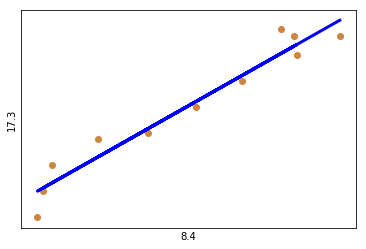

MAE: 0.17216
RAE: 0.23061
RMSE: 0.20054
R2: 0.944
Targets:  8.4 17.3
--------------------------




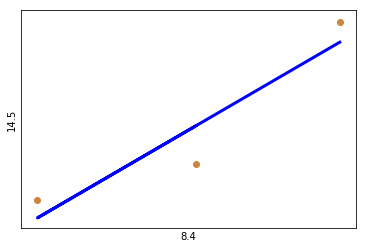

MAE: 0.16098
RAE: 0.35537
RMSE: 0.17081
R2: 0.878
Targets:  8.4 14.5
--------------------------


Targets:  8.4 8.2
--------------------------


Targets:  8.4 1.1
--------------------------




/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/felix/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


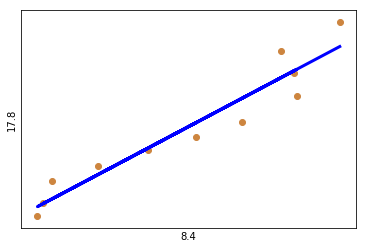

MAE: 0.13870
RAE: 0.27937
RMSE: 0.16849
R2: 0.917
Targets:  8.4 17.8
--------------------------


Targets:  8.4 3.6
--------------------------




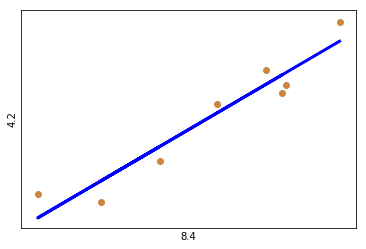

MAE: 0.10531
RAE: 0.31909
RMSE: 0.10928
R2: 0.916
Targets:  8.4 4.2
--------------------------




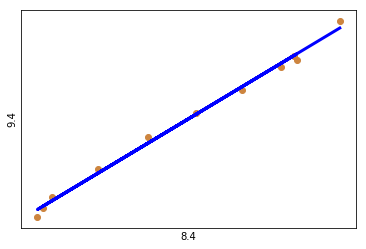

MAE: 0.04681
RAE: 0.06877
RMSE: 0.05329
R2: 0.995
Targets:  8.4 9.4
--------------------------


Targets:  8.4 6.b
--------------------------




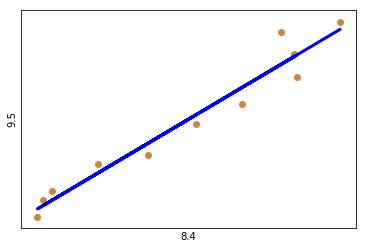

MAE: 0.13383
RAE: 0.20950
RMSE: 0.16067
R2: 0.951
Targets:  8.4 9.5
--------------------------


Targets:  8.4 10.c
--------------------------




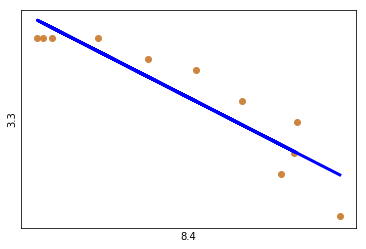

MAE: 0.18881
RAE: 0.40222
RMSE: 0.21200
R2: 0.844
Targets:  8.4 3.3
--------------------------




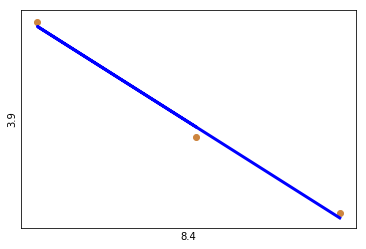

MAE: 0.06591
RAE: 0.09926
RMSE: 0.06994
R2: 0.992
Targets:  8.4 3.9
--------------------------


Targets:  8.4 15.2
--------------------------




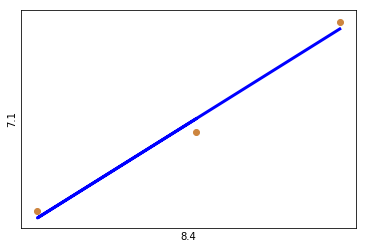

MAE: 0.07647
RAE: 0.13482
RMSE: 0.08114
R2: 0.985
Targets:  8.4 7.1
--------------------------




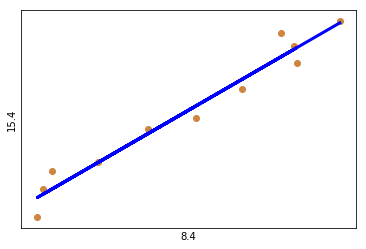

MAE: 0.12259
RAE: 0.18289
RMSE: 0.15316
R2: 0.959
Targets:  8.4 15.4
--------------------------




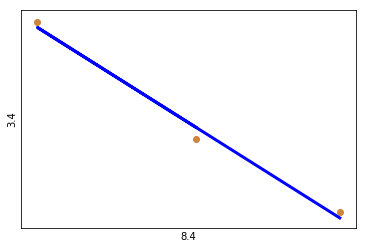

MAE: 0.06460
RAE: 0.11420
RMSE: 0.06854
R2: 0.989
Targets:  8.4 3.4
--------------------------




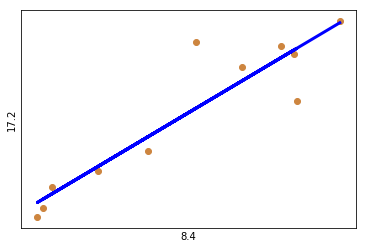

MAE: 0.21666
RAE: 0.27844
RMSE: 0.32270
R2: 0.850
Targets:  8.4 17.2
--------------------------


Targets:  8.4 2.1
--------------------------




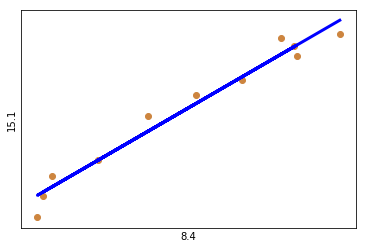

MAE: 0.13619
RAE: 0.16811
RMSE: 0.16587
R2: 0.967
Targets:  8.4 15.1
--------------------------


Targets:  8.4 9.c
--------------------------




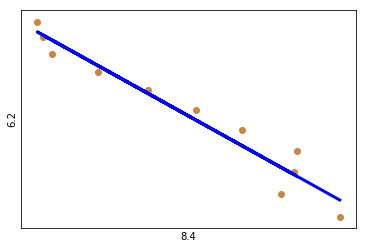

MAE: 0.12251
RAE: 0.22481
RMSE: 0.14812
R2: 0.944
Targets:  8.4 6.2
--------------------------




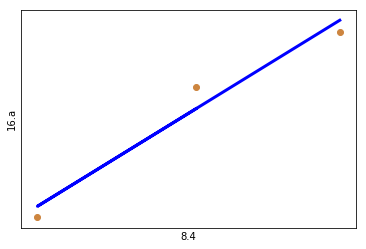

MAE: 0.15797
RAE: 0.20776
RMSE: 0.16762
R2: 0.960
Targets:  8.4 16.a
--------------------------




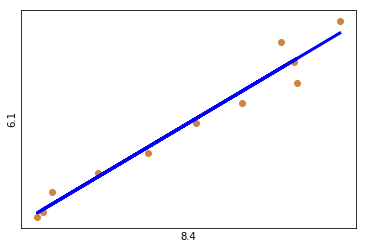

MAE: 0.13369
RAE: 0.17130
RMSE: 0.17177
R2: 0.962
Targets:  8.4 6.1
--------------------------


Targets:  8.4 8.1
--------------------------


Targets:  8.4 7.2
--------------------------


Targets:  8.4 16.3
--------------------------




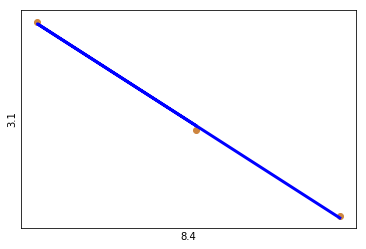

MAE: 0.02651
RAE: 0.04372
RMSE: 0.02813
R2: 0.998
Targets:  8.4 3.1
--------------------------


Targets:  8.4 17.19
--------------------------


Targets:  8.4 9.2
--------------------------


Targets:  8.4 14.4
--------------------------




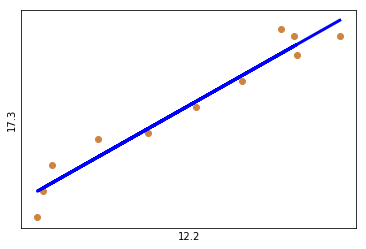

MAE: 0.17216
RAE: 0.23061
RMSE: 0.20054
R2: 0.944
Targets:  12.2 17.3
--------------------------




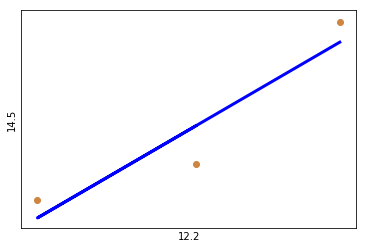

MAE: 0.16098
RAE: 0.35537
RMSE: 0.17081
R2: 0.878
Targets:  12.2 14.5
--------------------------


Targets:  12.2 8.2
--------------------------


Targets:  12.2 1.1
--------------------------




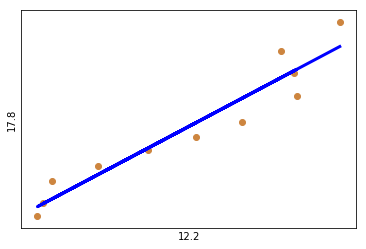

MAE: 0.13870
RAE: 0.27937
RMSE: 0.16849
R2: 0.917
Targets:  12.2 17.8
--------------------------


Targets:  12.2 3.6
--------------------------




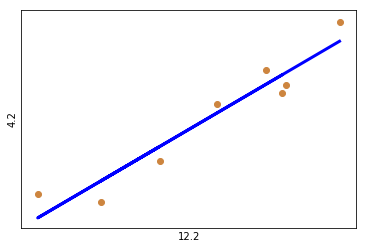

MAE: 0.10531
RAE: 0.31909
RMSE: 0.10928
R2: 0.916
Targets:  12.2 4.2
--------------------------




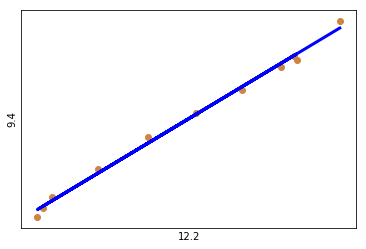

MAE: 0.04681
RAE: 0.06877
RMSE: 0.05329
R2: 0.995
Targets:  12.2 9.4
--------------------------


Targets:  12.2 6.b
--------------------------




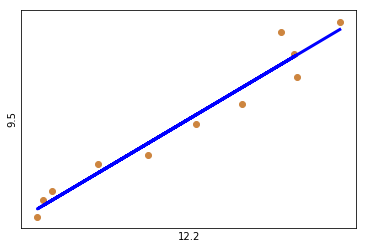

MAE: 0.13383
RAE: 0.20950
RMSE: 0.16067
R2: 0.951
Targets:  12.2 9.5
--------------------------


Targets:  12.2 10.c
--------------------------




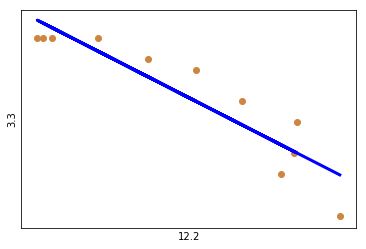

MAE: 0.18881
RAE: 0.40222
RMSE: 0.21200
R2: 0.844
Targets:  12.2 3.3
--------------------------




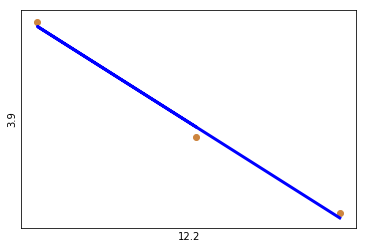

MAE: 0.06591
RAE: 0.09926
RMSE: 0.06994
R2: 0.992
Targets:  12.2 3.9
--------------------------


Targets:  12.2 15.2
--------------------------




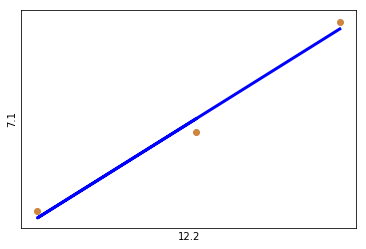

MAE: 0.07647
RAE: 0.13482
RMSE: 0.08114
R2: 0.985
Targets:  12.2 7.1
--------------------------




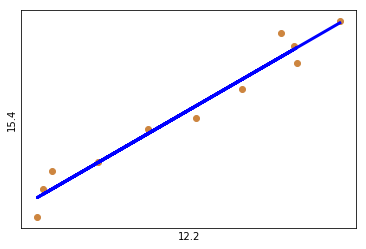

MAE: 0.12259
RAE: 0.18289
RMSE: 0.15316
R2: 0.959
Targets:  12.2 15.4
--------------------------




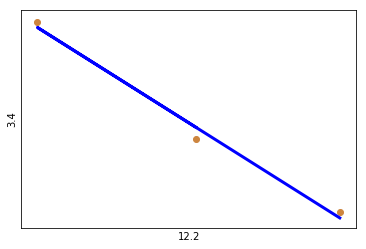

MAE: 0.06460
RAE: 0.11420
RMSE: 0.06854
R2: 0.989
Targets:  12.2 3.4
--------------------------




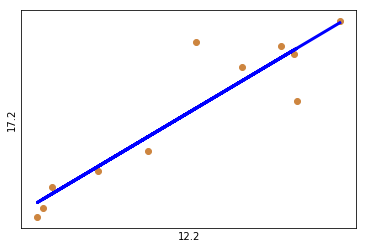

MAE: 0.21666
RAE: 0.27844
RMSE: 0.32270
R2: 0.850
Targets:  12.2 17.2
--------------------------


Targets:  12.2 2.1
--------------------------




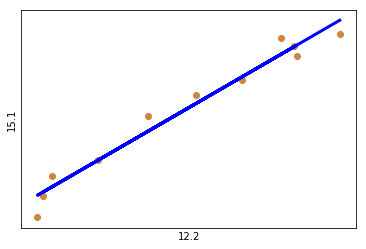

MAE: 0.13619
RAE: 0.16811
RMSE: 0.16587
R2: 0.967
Targets:  12.2 15.1
--------------------------


Targets:  12.2 9.c
--------------------------




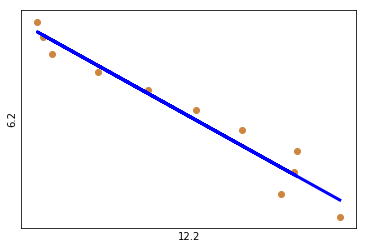

MAE: 0.12251
RAE: 0.22481
RMSE: 0.14812
R2: 0.944
Targets:  12.2 6.2
--------------------------




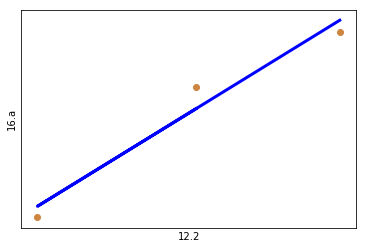

MAE: 0.15797
RAE: 0.20776
RMSE: 0.16762
R2: 0.960
Targets:  12.2 16.a
--------------------------




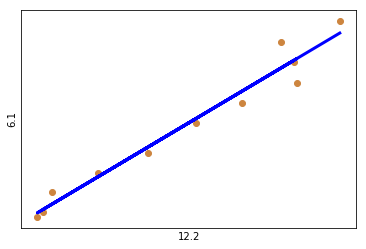

MAE: 0.13369
RAE: 0.17130
RMSE: 0.17177
R2: 0.962
Targets:  12.2 6.1
--------------------------


Targets:  12.2 8.1
--------------------------


Targets:  12.2 7.2
--------------------------


Targets:  12.2 16.3
--------------------------




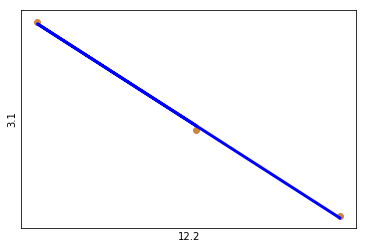

MAE: 0.02651
RAE: 0.04372
RMSE: 0.02813
R2: 0.998
Targets:  12.2 3.1
--------------------------


Targets:  12.2 17.19
--------------------------


Targets:  12.2 9.2
--------------------------


Targets:  12.2 14.4
--------------------------




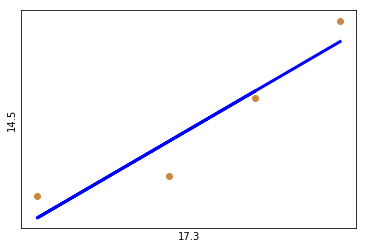

MAE: 0.24279
RAE: 0.33172
RMSE: 0.26900
R2: 0.887
Targets:  17.3 14.5
--------------------------


Targets:  17.3 8.2
--------------------------


Targets:  17.3 1.1
--------------------------




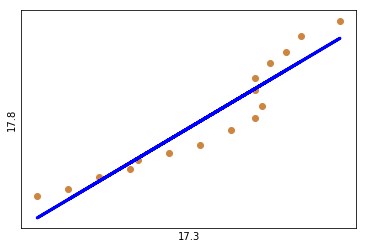

MAE: 0.27870
RAE: 0.33075
RMSE: 0.31967
R2: 0.891
Targets:  17.3 17.8
--------------------------


Targets:  17.3 3.6
--------------------------


Targets:  17.3 4.2
--------------------------




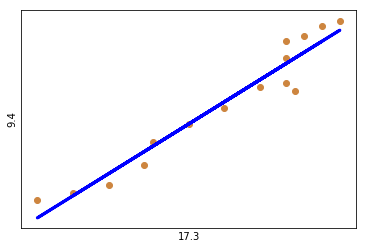

MAE: 0.19769
RAE: 0.23636
RMSE: 0.24166
R2: 0.937
Targets:  17.3 9.4
--------------------------


Targets:  17.3 6.b
--------------------------




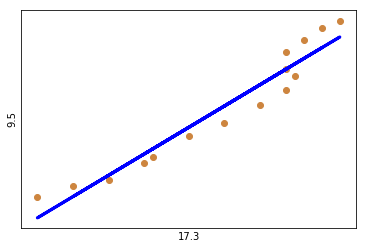

MAE: 0.22587
RAE: 0.26405
RMSE: 0.24919
R2: 0.933
Targets:  17.3 9.5
--------------------------




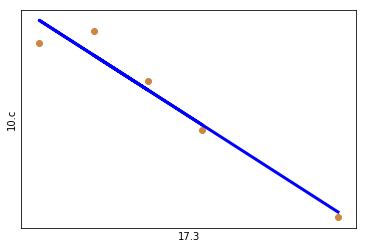

MAE: 0.17661
RAE: 0.22853
RMSE: 0.20953
R2: 0.945
Targets:  17.3 10.c
--------------------------




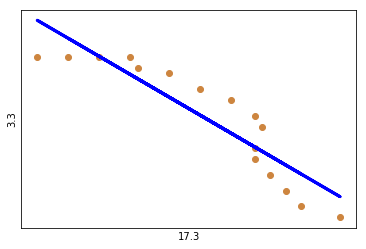

MAE: 0.36480
RAE: 0.42641
RMSE: 0.40741
R2: 0.823
Targets:  17.3 3.3
--------------------------




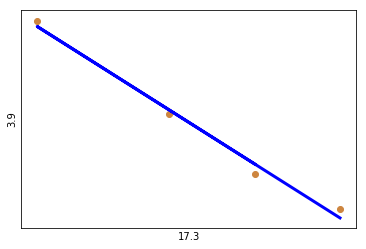

MAE: 0.08706
RAE: 0.11530
RMSE: 0.09338
R2: 0.988
Targets:  17.3 3.9
--------------------------


Targets:  17.3 15.2
--------------------------




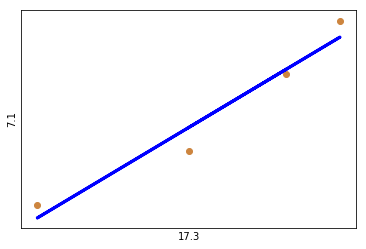

MAE: 0.17392
RAE: 0.21727
RMSE: 0.19128
R2: 0.951
Targets:  17.3 7.1
--------------------------




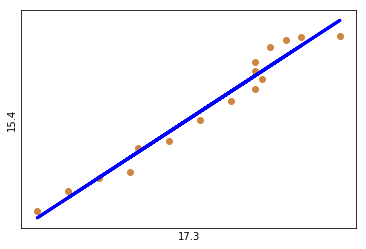

MAE: 0.16512
RAE: 0.19569
RMSE: 0.18415
R2: 0.963
Targets:  17.3 15.4
--------------------------




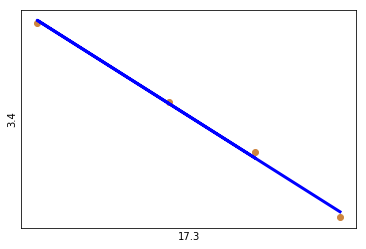

MAE: 0.04627
RAE: 0.06221
RMSE: 0.05138
R2: 0.996
Targets:  17.3 3.4
--------------------------




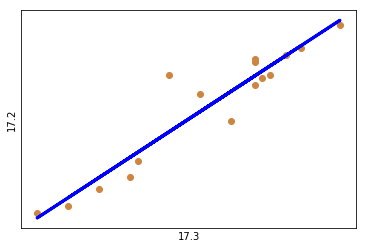

MAE: 0.21113
RAE: 0.26520
RMSE: 0.28990
R2: 0.896
Targets:  17.3 17.2
--------------------------




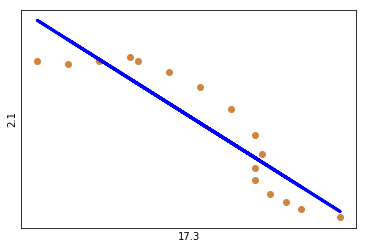

MAE: 0.24808
RAE: 0.40269
RMSE: 0.27505
R2: 0.828
Targets:  17.3 2.1
--------------------------




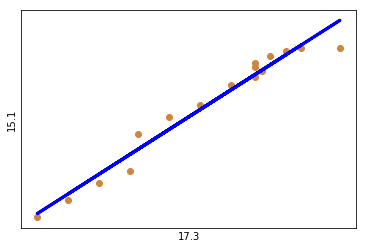

MAE: 0.14956
RAE: 0.17779
RMSE: 0.18861
R2: 0.963
Targets:  17.3 15.1
--------------------------


Targets:  17.3 9.c
--------------------------




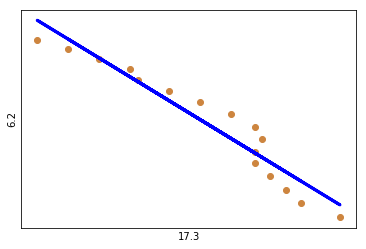

MAE: 0.23697
RAE: 0.28142
RMSE: 0.27408
R2: 0.920
Targets:  17.3 6.2
--------------------------




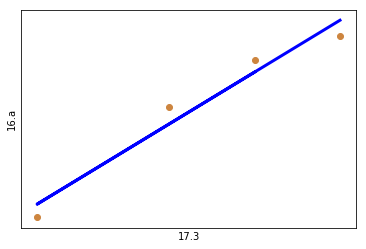

MAE: 0.18319
RAE: 0.25029
RMSE: 0.18509
R2: 0.957
Targets:  17.3 16.a
--------------------------




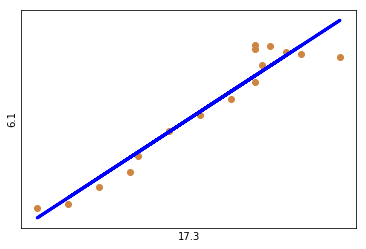

MAE: 0.20127
RAE: 0.23212
RMSE: 0.26570
R2: 0.925
Targets:  17.3 6.1
--------------------------


Targets:  17.3 8.1
--------------------------


Targets:  17.3 7.2
--------------------------


Targets:  17.3 16.3
--------------------------




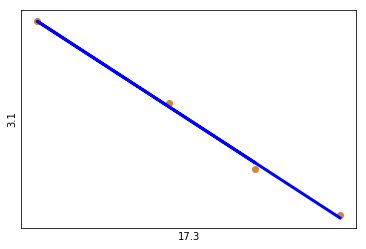

MAE: 0.03773
RAE: 0.04902
RMSE: 0.04524
R2: 0.997
Targets:  17.3 3.1
--------------------------


Targets:  17.3 17.19
--------------------------


Targets:  17.3 9.2
--------------------------


Targets:  17.3 14.4
--------------------------


Targets:  14.5 8.2
--------------------------


Targets:  14.5 1.1
--------------------------




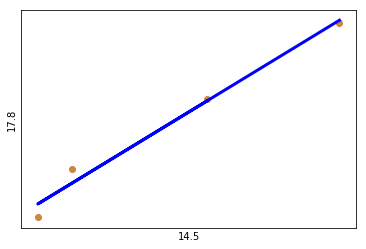

MAE: 0.12571
RAE: 0.11822
RMSE: 0.15572
R2: 0.983
Targets:  14.5 17.8
--------------------------


Targets:  14.5 3.6
--------------------------


Targets:  14.5 4.2
--------------------------




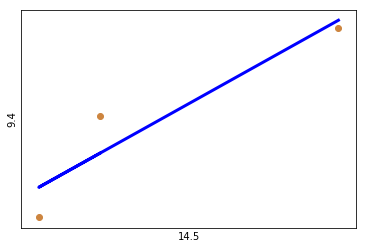

MAE: 0.29773
RAE: 0.38374
RMSE: 0.33367
R2: 0.871
Targets:  14.5 9.4
--------------------------


Targets:  14.5 6.b
--------------------------




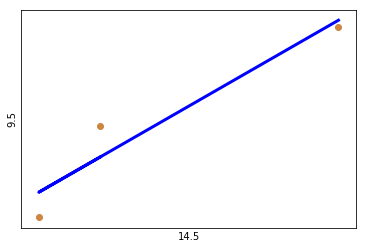

MAE: 0.23043
RAE: 0.31787
RMSE: 0.25824
R2: 0.913
Targets:  14.5 9.5
--------------------------


Targets:  14.5 10.c
--------------------------




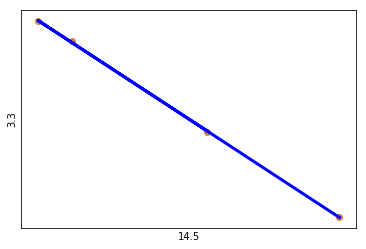

MAE: 0.01766
RAE: 0.01724
RMSE: 0.01907
R2: 1.000
Targets:  14.5 3.3
--------------------------




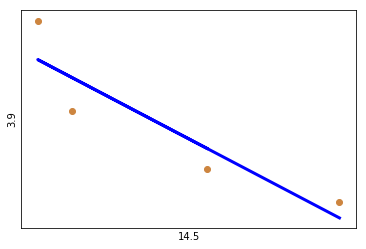

MAE: 0.33851
RAE: 0.44833
RMSE: 0.35737
R2: 0.830
Targets:  14.5 3.9
--------------------------


Targets:  14.5 15.2
--------------------------




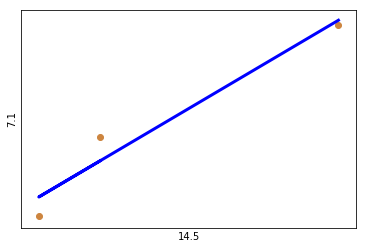

MAE: 0.13639
RAE: 0.24046
RMSE: 0.15285
R2: 0.947
Targets:  14.5 7.1
--------------------------




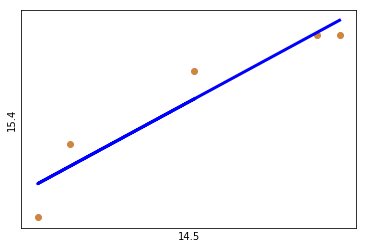

MAE: 0.31988
RAE: 0.31396
RMSE: 0.36266
R2: 0.896
Targets:  14.5 15.4
--------------------------




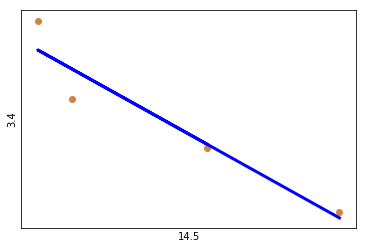

MAE: 0.21304
RAE: 0.28643
RMSE: 0.26222
R2: 0.908
Targets:  14.5 3.4
--------------------------


Targets:  14.5 17.2
--------------------------




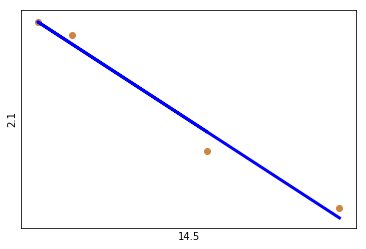

MAE: 0.08741
RAE: 0.12468
RMSE: 0.10690
R2: 0.978
Targets:  14.5 2.1
--------------------------


Targets:  14.5 15.1
--------------------------


Targets:  14.5 9.c
--------------------------




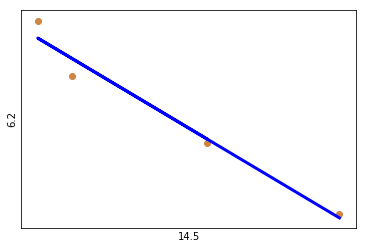

MAE: 0.17119
RAE: 0.16273
RMSE: 0.20184
R2: 0.970
Targets:  14.5 6.2
--------------------------


Targets:  14.5 16.a
--------------------------


Targets:  14.5 6.1
--------------------------


Targets:  14.5 8.1
--------------------------


Targets:  14.5 7.2
--------------------------


Targets:  14.5 16.3
--------------------------




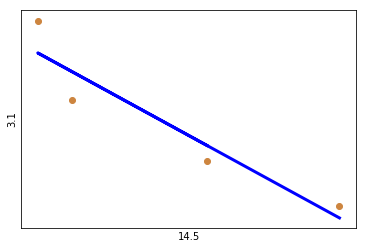

MAE: 0.27330
RAE: 0.35508
RMSE: 0.29100
R2: 0.887
Targets:  14.5 3.1
--------------------------


Targets:  14.5 17.19
--------------------------




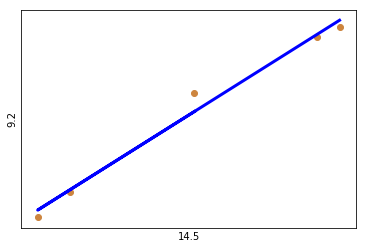

MAE: 0.08447
RAE: 0.10163
RMSE: 0.10804
R2: 0.985
Targets:  14.5 9.2
--------------------------


Targets:  14.5 14.4
--------------------------


Targets:  8.2 1.1
--------------------------


Targets:  8.2 17.8
--------------------------


Targets:  8.2 3.6
--------------------------


Targets:  8.2 4.2
--------------------------


Targets:  8.2 9.4
--------------------------


Targets:  8.2 6.b
--------------------------


Targets:  8.2 9.5
--------------------------


Targets:  8.2 10.c
--------------------------


Targets:  8.2 3.3
--------------------------


Targets:  8.2 3.9
--------------------------


Targets:  8.2 15.2
--------------------------


Targets:  8.2 7.1
--------------------------


Targets:  8.2 15.4
--------------------------


Targets:  8.2 3.4
--------------------------


Targets:  8.2 17.2
--------------------------


Targets:  8.2 2.1
--------------------------


Targets:  8.2 15.1
--------------------------


Targets:  8.2 9.c
--------------------------


T

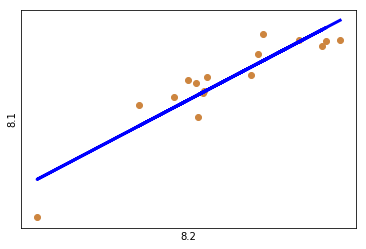

MAE: 0.32716
RAE: 0.49197
RMSE: 0.39184
R2: 0.836
Targets:  8.2 8.1
--------------------------


Targets:  8.2 7.2
--------------------------


Targets:  8.2 16.3
--------------------------


Targets:  8.2 3.1
--------------------------


Targets:  8.2 17.19
--------------------------


Targets:  8.2 9.2
--------------------------


Targets:  8.2 14.4
--------------------------


Targets:  1.1 17.8
--------------------------


Targets:  1.1 3.6
--------------------------


Targets:  1.1 4.2
--------------------------


Targets:  1.1 9.4
--------------------------


Targets:  1.1 6.b
--------------------------


Targets:  1.1 9.5
--------------------------


Targets:  1.1 10.c
--------------------------


Targets:  1.1 3.3
--------------------------


Targets:  1.1 3.9
--------------------------


Targets:  1.1 15.2
--------------------------


Targets:  1.1 7.1
--------------------------


Targets:  1.1 15.4
--------------------------


Targets:  1.1 3.4
--------------------------


Ta

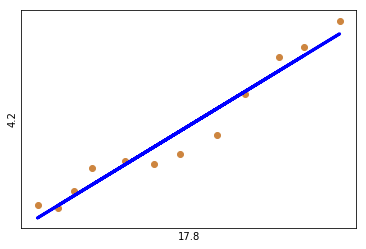

MAE: 0.19006
RAE: 0.23041
RMSE: 0.22488
R2: 0.945
Targets:  17.8 4.2
--------------------------




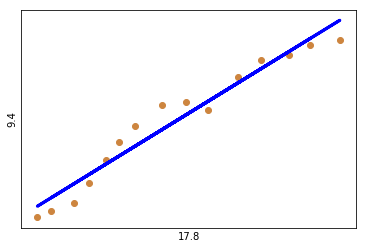

MAE: 0.19463
RAE: 0.23269
RMSE: 0.21994
R2: 0.948
Targets:  17.8 9.4
--------------------------


Targets:  17.8 6.b
--------------------------




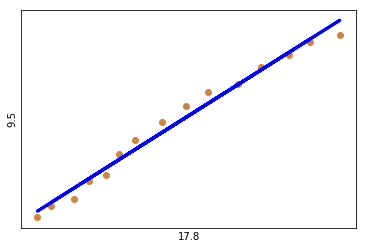

MAE: 0.11023
RAE: 0.12886
RMSE: 0.13036
R2: 0.982
Targets:  17.8 9.5
--------------------------




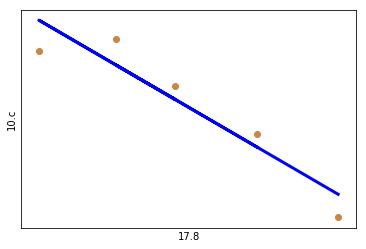

MAE: 0.29241
RAE: 0.37836
RMSE: 0.30744
R2: 0.882
Targets:  17.8 10.c
--------------------------




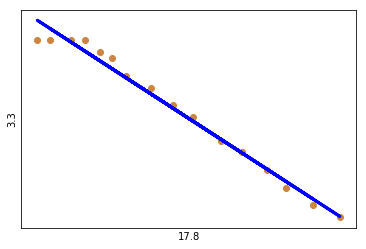

MAE: 0.09281
RAE: 0.10849
RMSE: 0.12488
R2: 0.983
Targets:  17.8 3.3
--------------------------




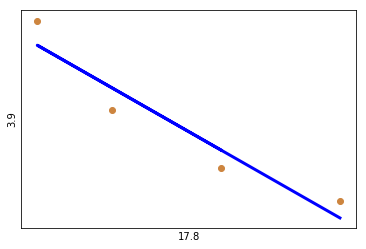

MAE: 0.25678
RAE: 0.34007
RMSE: 0.25936
R2: 0.910
Targets:  17.8 3.9
--------------------------


Targets:  17.8 15.2
--------------------------




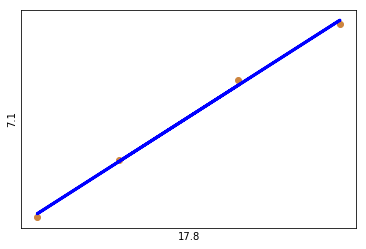

MAE: 0.04225
RAE: 0.05278
RMSE: 0.04537
R2: 0.997
Targets:  17.8 7.1
--------------------------




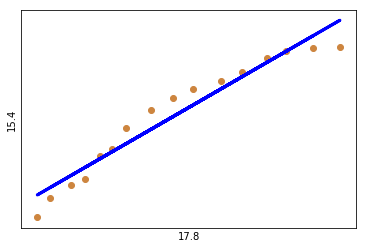

MAE: 0.19793
RAE: 0.23457
RMSE: 0.23490
R2: 0.939
Targets:  17.8 15.4
--------------------------




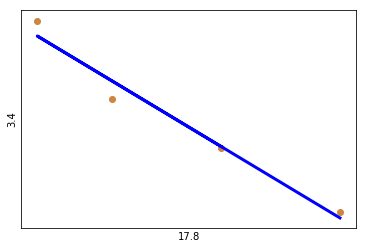

MAE: 0.12637
RAE: 0.16991
RMSE: 0.15114
R2: 0.970
Targets:  17.8 3.4
--------------------------


Targets:  17.8 17.2
--------------------------




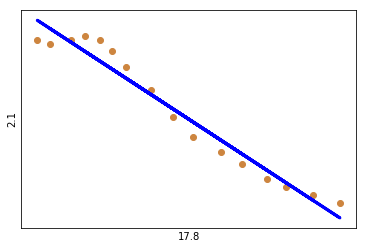

MAE: 0.12459
RAE: 0.20225
RMSE: 0.13771
R2: 0.957
Targets:  17.8 2.1
--------------------------




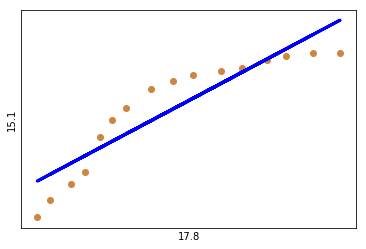

MAE: 0.35495
RAE: 0.42196
RMSE: 0.39769
R2: 0.833
Targets:  17.8 15.1
--------------------------


Targets:  17.8 9.c
--------------------------




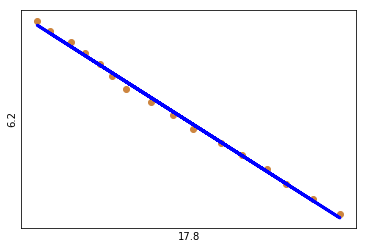

MAE: 0.04886
RAE: 0.05802
RMSE: 0.05709
R2: 0.997
Targets:  17.8 6.2
--------------------------




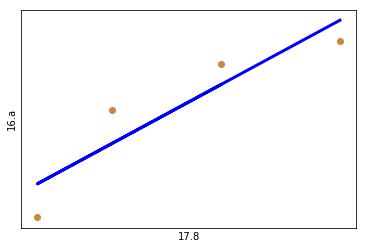

MAE: 0.35308
RAE: 0.48240
RMSE: 0.36308
R2: 0.834
Targets:  17.8 16.a
--------------------------




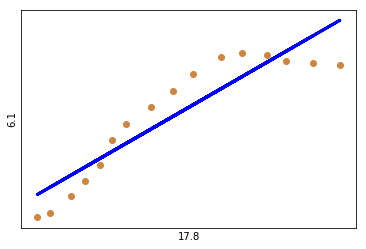

MAE: 0.35409
RAE: 0.40837
RMSE: 0.38932
R2: 0.838
Targets:  17.8 6.1
--------------------------


Targets:  17.8 8.1
--------------------------


Targets:  17.8 7.2
--------------------------


Targets:  17.8 16.3
--------------------------




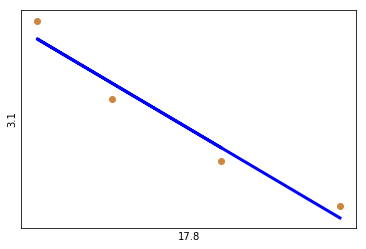

MAE: 0.18788
RAE: 0.24410
RMSE: 0.18959
R2: 0.952
Targets:  17.8 3.1
--------------------------


Targets:  17.8 17.19
--------------------------


Targets:  17.8 9.2
--------------------------




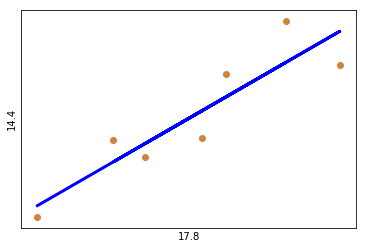

MAE: 0.31008
RAE: 0.45683
RMSE: 0.33473
R2: 0.813
Targets:  17.8 14.4
--------------------------




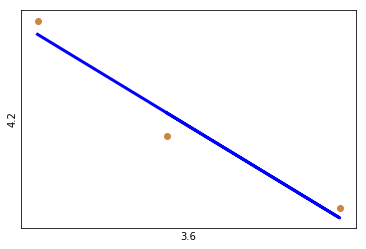

MAE: 0.18305
RAE: 0.22585
RMSE: 0.19482
R2: 0.956
Targets:  3.6 4.2
--------------------------


Targets:  3.6 9.4
--------------------------


Targets:  3.6 6.b
--------------------------


Targets:  3.6 9.5
--------------------------


Targets:  3.6 10.c
--------------------------


Targets:  3.6 3.3
--------------------------


Targets:  3.6 3.9
--------------------------


Targets:  3.6 15.2
--------------------------


Targets:  3.6 7.1
--------------------------


Targets:  3.6 15.4
--------------------------


Targets:  3.6 3.4
--------------------------


Targets:  3.6 17.2
--------------------------


Targets:  3.6 2.1
--------------------------


Targets:  3.6 15.1
--------------------------




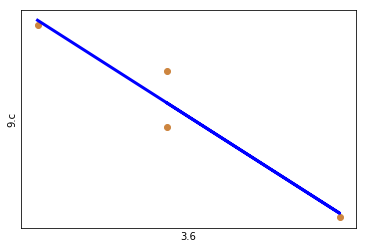

MAE: 0.17501
RAE: 0.25681
RMSE: 0.22100
R2: 0.921
Targets:  3.6 9.c
--------------------------


Targets:  3.6 6.2
--------------------------


Targets:  3.6 16.a
--------------------------


Targets:  3.6 6.1
--------------------------


Targets:  3.6 8.1
--------------------------




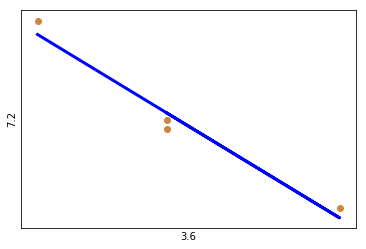

MAE: 0.17394
RAE: 0.23674
RMSE: 0.18083
R2: 0.967
Targets:  3.6 7.2
--------------------------


Targets:  3.6 16.3
--------------------------


Targets:  3.6 3.1
--------------------------


Targets:  3.6 17.19
--------------------------


Targets:  3.6 9.2
--------------------------




/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3013: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


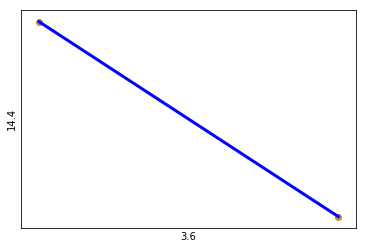

MAE: 0.00000
RAE: nan
RMSE: 0.00000
R2: nan
Targets:  3.6 14.4
--------------------------




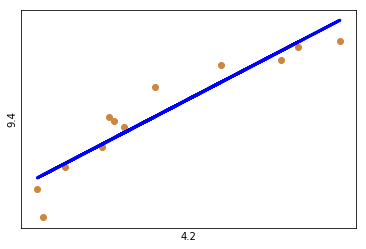

MAE: 0.20524
RAE: 0.33620
RMSE: 0.25498
R2: 0.877
Targets:  4.2 9.4
--------------------------


Targets:  4.2 6.b
--------------------------




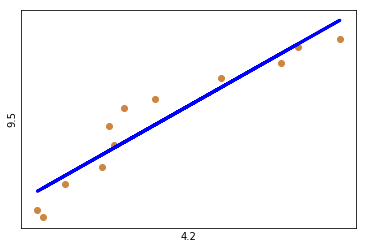

MAE: 0.21597
RAE: 0.31795
RMSE: 0.25325
R2: 0.895
Targets:  4.2 9.5
--------------------------


Targets:  4.2 10.c
--------------------------




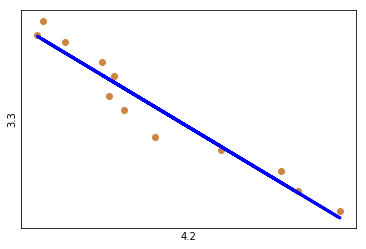

MAE: 0.16223
RAE: 0.22242
RMSE: 0.19707
R2: 0.945
Targets:  4.2 3.3
--------------------------


Targets:  4.2 3.9
--------------------------


Targets:  4.2 15.2
--------------------------




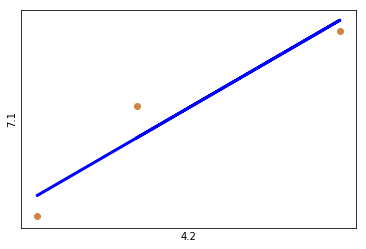

MAE: 0.17819
RAE: 0.31701
RMSE: 0.19264
R2: 0.913
Targets:  4.2 7.1
--------------------------




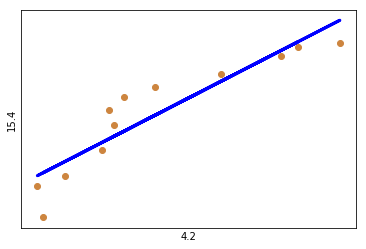

MAE: 0.23325
RAE: 0.38256
RMSE: 0.28311
R2: 0.842
Targets:  4.2 15.4
--------------------------


Targets:  4.2 3.4
--------------------------


Targets:  4.2 17.2
--------------------------




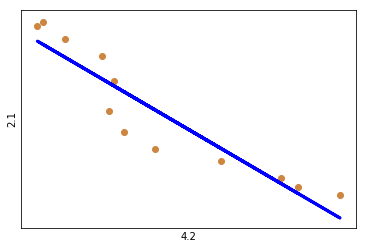

MAE: 0.19330
RAE: 0.35597
RMSE: 0.22222
R2: 0.865
Targets:  4.2 2.1
--------------------------


Targets:  4.2 15.1
--------------------------


Targets:  4.2 9.c
--------------------------




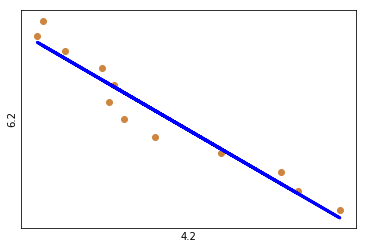

MAE: 0.15723
RAE: 0.24240
RMSE: 0.19196
R2: 0.934
Targets:  4.2 6.2
--------------------------


Targets:  4.2 16.a
--------------------------


Targets:  4.2 6.1
--------------------------


Targets:  4.2 8.1
--------------------------




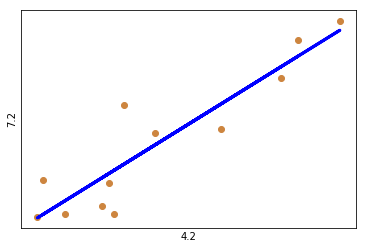

MAE: 0.34977
RAE: 0.37005
RMSE: 0.43417
R2: 0.836
Targets:  4.2 7.2
--------------------------


Targets:  4.2 16.3
--------------------------


Targets:  4.2 3.1
--------------------------


Targets:  4.2 17.19
--------------------------


Targets:  4.2 9.2
--------------------------


Targets:  4.2 14.4
--------------------------


Targets:  9.4 6.b
--------------------------




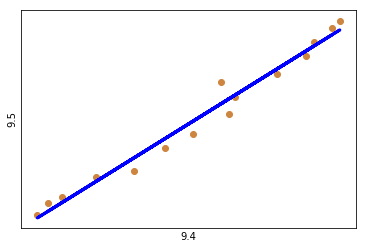

MAE: 0.12508
RAE: 0.14622
RMSE: 0.14902
R2: 0.976
Targets:  9.4 9.5
--------------------------




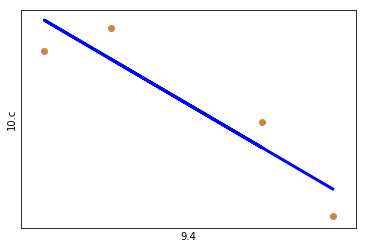

MAE: 0.20091
RAE: 0.44620
RMSE: 0.20169
R2: 0.843
Targets:  9.4 10.c
--------------------------




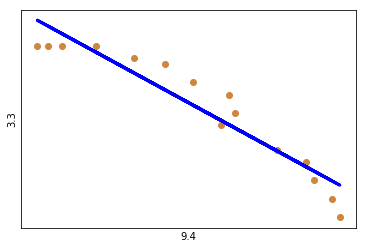

MAE: 0.24524
RAE: 0.31288
RMSE: 0.28357
R2: 0.898
Targets:  9.4 3.3
--------------------------




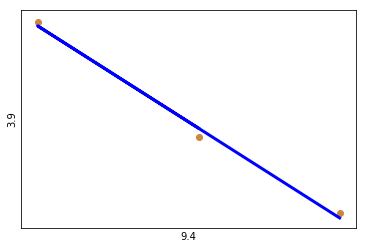

MAE: 0.05835
RAE: 0.08788
RMSE: 0.06194
R2: 0.993
Targets:  9.4 3.9
--------------------------


Targets:  9.4 15.2
--------------------------




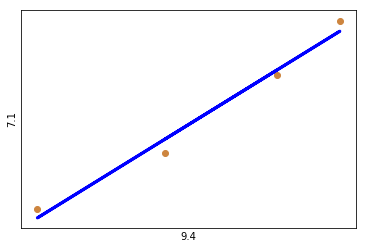

MAE: 0.11397
RAE: 0.14238
RMSE: 0.12018
R2: 0.981
Targets:  9.4 7.1
--------------------------




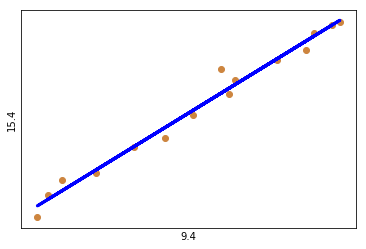

MAE: 0.09210
RAE: 0.11144
RMSE: 0.12700
R2: 0.981
Targets:  9.4 15.4
--------------------------




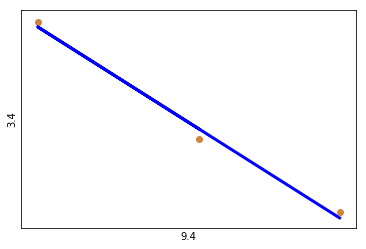

MAE: 0.05820
RAE: 0.10289
RMSE: 0.06178
R2: 0.991
Targets:  9.4 3.4
--------------------------




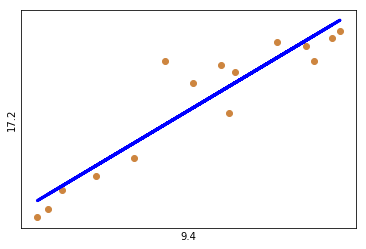

MAE: 0.25366
RAE: 0.32424
RMSE: 0.31400
R2: 0.869
Targets:  9.4 17.2
--------------------------




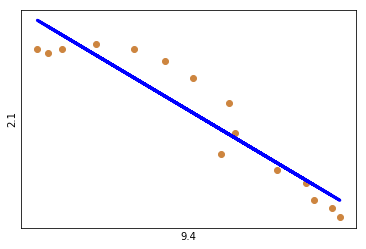

MAE: 0.19143
RAE: 0.32656
RMSE: 0.21764
R2: 0.881
Targets:  9.4 2.1
--------------------------




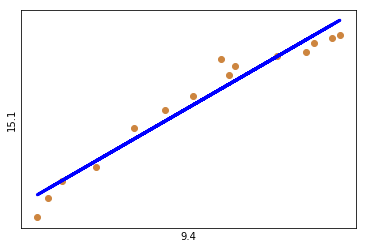

MAE: 0.18679
RAE: 0.22145
RMSE: 0.21928
R2: 0.949
Targets:  9.4 15.1
--------------------------


Targets:  9.4 9.c
--------------------------




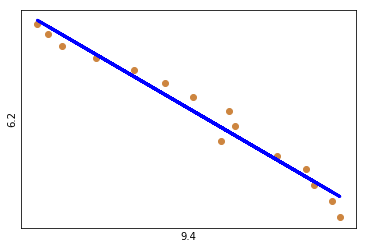

MAE: 0.14416
RAE: 0.18477
RMSE: 0.16508
R2: 0.966
Targets:  9.4 6.2
--------------------------




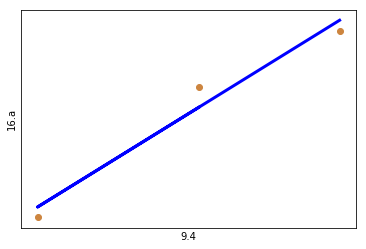

MAE: 0.14975
RAE: 0.19695
RMSE: 0.15895
R2: 0.964
Targets:  9.4 16.a
--------------------------




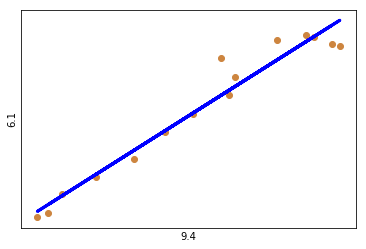

MAE: 0.15047
RAE: 0.17244
RMSE: 0.21511
R2: 0.951
Targets:  9.4 6.1
--------------------------


Targets:  9.4 8.1
--------------------------


Targets:  9.4 7.2
--------------------------


Targets:  9.4 16.3
--------------------------




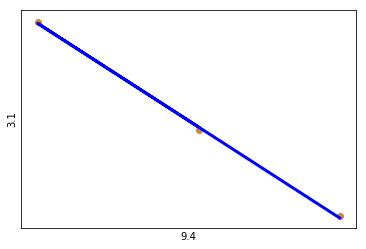

MAE: 0.01943
RAE: 0.03205
RMSE: 0.02063
R2: 0.999
Targets:  9.4 3.1
--------------------------


Targets:  9.4 17.19
--------------------------


Targets:  9.4 9.2
--------------------------


Targets:  9.4 14.4
--------------------------


Targets:  6.b 9.5
--------------------------


Targets:  6.b 10.c
--------------------------


Targets:  6.b 3.3
--------------------------


Targets:  6.b 3.9
--------------------------


Targets:  6.b 15.2
--------------------------


Targets:  6.b 7.1
--------------------------




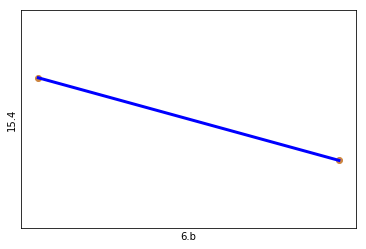

MAE: 0.00000
RAE: nan
RMSE: 0.00000
R2: nan
Targets:  6.b 15.4
--------------------------


Targets:  6.b 3.4
--------------------------


Targets:  6.b 17.2
--------------------------


Targets:  6.b 2.1
--------------------------


Targets:  6.b 15.1
--------------------------


Targets:  6.b 9.c
--------------------------


Targets:  6.b 6.2
--------------------------


Targets:  6.b 16.a
--------------------------


Targets:  6.b 6.1
--------------------------


Targets:  6.b 8.1
--------------------------


Targets:  6.b 7.2
--------------------------


Targets:  6.b 16.3
--------------------------


Targets:  6.b 3.1
--------------------------


Targets:  6.b 17.19
--------------------------


Targets:  6.b 9.2
--------------------------


Targets:  6.b 14.4
--------------------------


Targets:  9.5 10.c
--------------------------




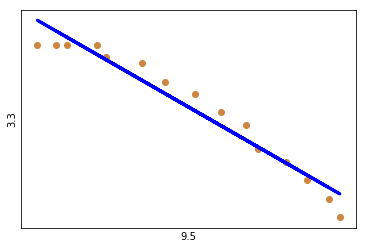

MAE: 0.17760
RAE: 0.22658
RMSE: 0.20522
R2: 0.947
Targets:  9.5 3.3
--------------------------




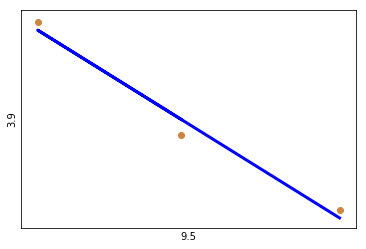

MAE: 0.10620
RAE: 0.15994
RMSE: 0.11269
R2: 0.978
Targets:  9.5 3.9
--------------------------


Targets:  9.5 15.2
--------------------------




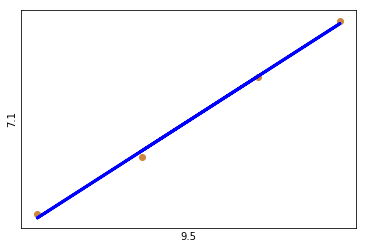

MAE: 0.03643
RAE: 0.04551
RMSE: 0.04422
R2: 0.997
Targets:  9.5 7.1
--------------------------




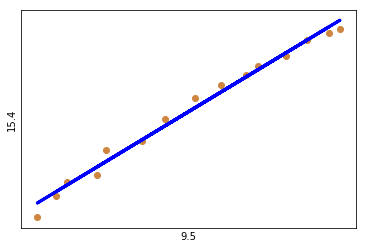

MAE: 0.09233
RAE: 0.11172
RMSE: 0.10933
R2: 0.986
Targets:  9.5 15.4
--------------------------




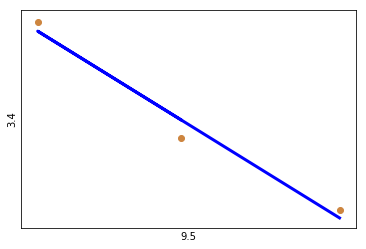

MAE: 0.09865
RAE: 0.17440
RMSE: 0.10468
R2: 0.974
Targets:  9.5 3.4
--------------------------




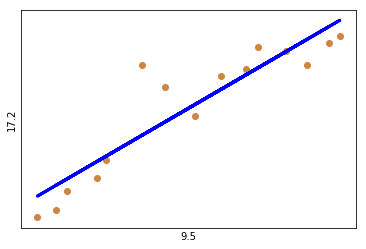

MAE: 0.26856
RAE: 0.34327
RMSE: 0.34652
R2: 0.840
Targets:  9.5 17.2
--------------------------




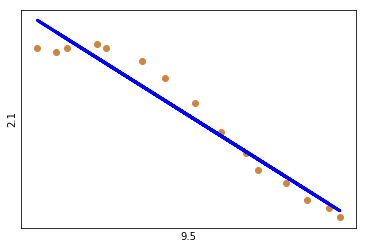

MAE: 0.12699
RAE: 0.21663
RMSE: 0.14932
R2: 0.944
Targets:  9.5 2.1
--------------------------




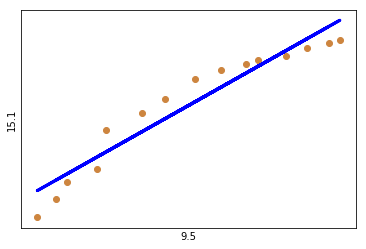

MAE: 0.25647
RAE: 0.30406
RMSE: 0.27738
R2: 0.918
Targets:  9.5 15.1
--------------------------


Targets:  9.5 9.c
--------------------------




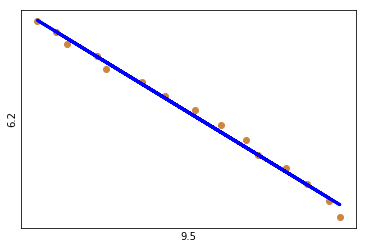

MAE: 0.05726
RAE: 0.07339
RMSE: 0.07622
R2: 0.993
Targets:  9.5 6.2
--------------------------




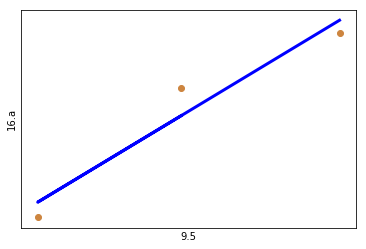

MAE: 0.20147
RAE: 0.26496
RMSE: 0.21378
R2: 0.936
Targets:  9.5 16.a
--------------------------




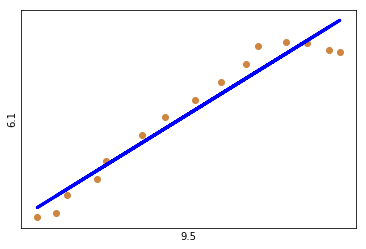

MAE: 0.19785
RAE: 0.22675
RMSE: 0.23262
R2: 0.943
Targets:  9.5 6.1
--------------------------


Targets:  9.5 8.1
--------------------------


Targets:  9.5 7.2
--------------------------


Targets:  9.5 16.3
--------------------------




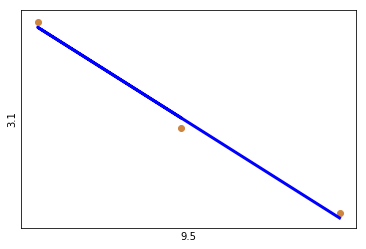

MAE: 0.06438
RAE: 0.10618
RMSE: 0.06832
R2: 0.991
Targets:  9.5 3.1
--------------------------


Targets:  9.5 17.19
--------------------------


Targets:  9.5 9.2
--------------------------


Targets:  9.5 14.4
--------------------------




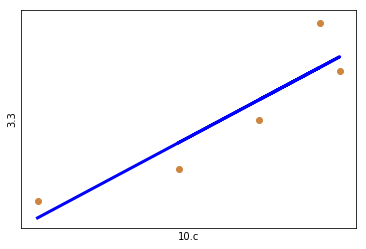

MAE: 0.14050
RAE: 0.43862
RMSE: 0.15379
R2: 0.827
Targets:  10.c 3.3
--------------------------


Targets:  10.c 3.9
--------------------------


Targets:  10.c 15.2
--------------------------


Targets:  10.c 7.1
--------------------------


Targets:  10.c 15.4
--------------------------


Targets:  10.c 3.4
--------------------------




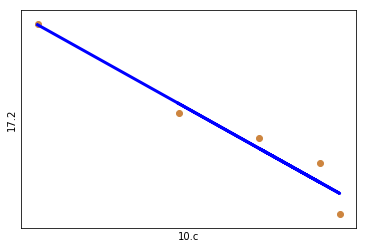

MAE: 0.04884
RAE: 0.24679
RMSE: 0.05663
R2: 0.949
Targets:  10.c 17.2
--------------------------


Targets:  10.c 2.1
--------------------------


Targets:  10.c 15.1
--------------------------


Targets:  10.c 9.c
--------------------------




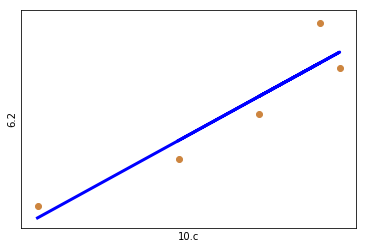

MAE: 0.10959
RAE: 0.38107
RMSE: 0.12129
R2: 0.872
Targets:  10.c 6.2
--------------------------


Targets:  10.c 16.a
--------------------------




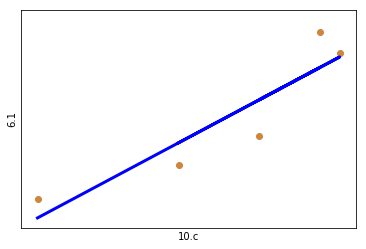

MAE: 0.02804
RAE: 0.39569
RMSE: 0.03149
R2: 0.830
Targets:  10.c 6.1
--------------------------


Targets:  10.c 8.1
--------------------------


Targets:  10.c 7.2
--------------------------


Targets:  10.c 16.3
--------------------------


Targets:  10.c 3.1
--------------------------


Targets:  10.c 17.19
--------------------------




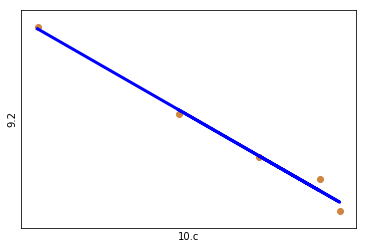

MAE: 0.01080
RAE: 0.10205
RMSE: 0.01374
R2: 0.988
Targets:  10.c 9.2
--------------------------


Targets:  10.c 14.4
--------------------------




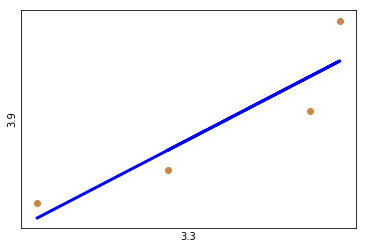

MAE: 0.34087
RAE: 0.45145
RMSE: 0.36383
R2: 0.823
Targets:  3.3 3.9
--------------------------


Targets:  3.3 15.2
--------------------------




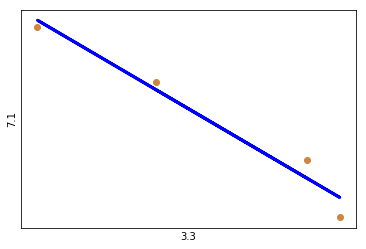

MAE: 0.15671
RAE: 0.19577
RMSE: 0.17031
R2: 0.961
Targets:  3.3 7.1
--------------------------




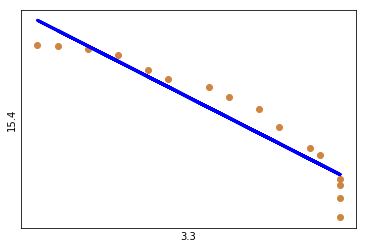

MAE: 0.25852
RAE: 0.30638
RMSE: 0.30941
R2: 0.894
Targets:  3.3 15.4
--------------------------




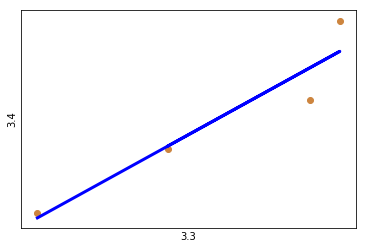

MAE: 0.21544
RAE: 0.28967
RMSE: 0.27270
R2: 0.901
Targets:  3.3 3.4
--------------------------


Targets:  3.3 17.2
--------------------------




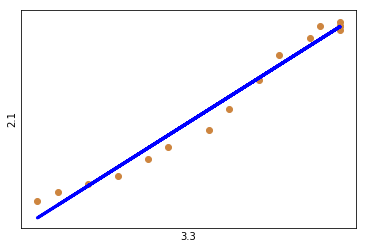

MAE: 0.08653
RAE: 0.14046
RMSE: 0.10360
R2: 0.976
Targets:  3.3 2.1
--------------------------


Targets:  3.3 15.1
--------------------------


Targets:  3.3 9.c
--------------------------




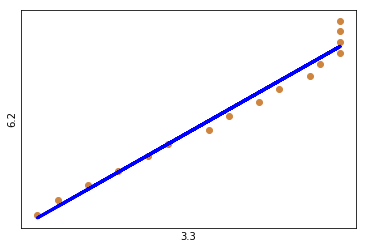

MAE: 0.12160
RAE: 0.14441
RMSE: 0.15717
R2: 0.974
Targets:  3.3 6.2
--------------------------


Targets:  3.3 16.a
--------------------------


Targets:  3.3 6.1
--------------------------


Targets:  3.3 8.1
--------------------------


Targets:  3.3 7.2
--------------------------


Targets:  3.3 16.3
--------------------------




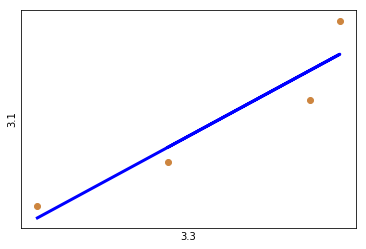

MAE: 0.27584
RAE: 0.35838
RMSE: 0.29811
R2: 0.882
Targets:  3.3 3.1
--------------------------


Targets:  3.3 17.19
--------------------------


Targets:  3.3 9.2
--------------------------


Targets:  3.3 14.4
--------------------------


Targets:  3.9 15.2
--------------------------




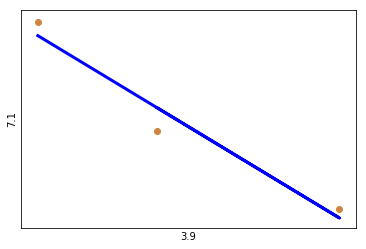

MAE: 0.13172
RAE: 0.23223
RMSE: 0.14070
R2: 0.955
Targets:  3.9 7.1
--------------------------




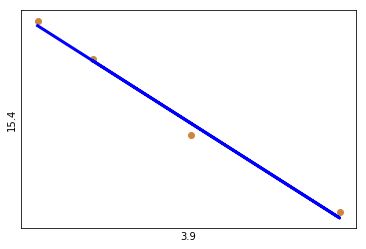

MAE: 0.09072
RAE: 0.08967
RMSE: 0.10714
R2: 0.991
Targets:  3.9 15.4
--------------------------




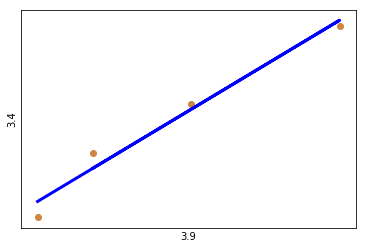

MAE: 0.13050
RAE: 0.17546
RMSE: 0.14418
R2: 0.972
Targets:  3.9 3.4
--------------------------




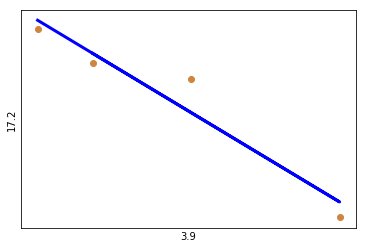

MAE: 0.24970
RAE: 0.27551
RMSE: 0.29076
R2: 0.928
Targets:  3.9 17.2
--------------------------




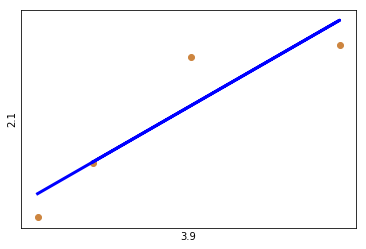

MAE: 0.24576
RAE: 0.35052
RMSE: 0.29821
R2: 0.832
Targets:  3.9 2.1
--------------------------




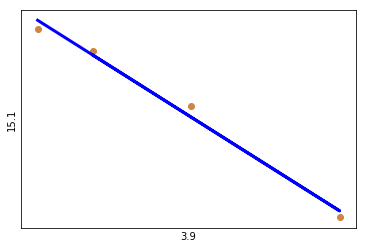

MAE: 0.11809
RAE: 0.12393
RMSE: 0.12383
R2: 0.988
Targets:  3.9 15.1
--------------------------


Targets:  3.9 9.c
--------------------------




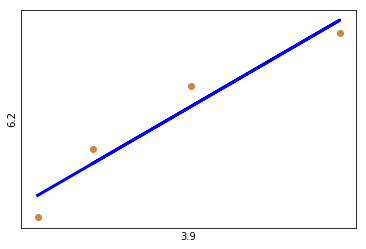

MAE: 0.29628
RAE: 0.28165
RMSE: 0.30356
R2: 0.933
Targets:  3.9 6.2
--------------------------




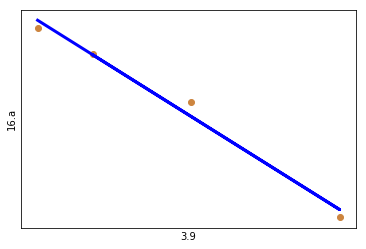

MAE: 0.09334
RAE: 0.12752
RMSE: 0.10801
R2: 0.985
Targets:  3.9 16.a
--------------------------




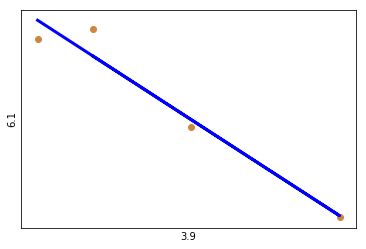

MAE: 0.18834
RAE: 0.19515
RMSE: 0.23391
R2: 0.952
Targets:  3.9 6.1
--------------------------


Targets:  3.9 8.1
--------------------------


Targets:  3.9 7.2
--------------------------


Targets:  3.9 16.3
--------------------------




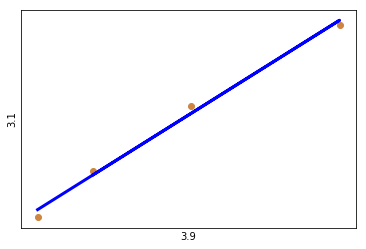

MAE: 0.07010
RAE: 0.09107
RMSE: 0.07221
R2: 0.993
Targets:  3.9 3.1
--------------------------


Targets:  3.9 17.19
--------------------------




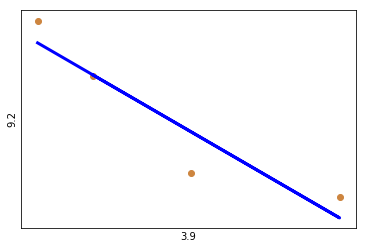

MAE: 0.24908
RAE: 0.31347
RMSE: 0.29905
R2: 0.871
Targets:  3.9 9.2
--------------------------


Targets:  3.9 14.4
--------------------------


Targets:  15.2 7.1
--------------------------


Targets:  15.2 15.4
--------------------------


Targets:  15.2 3.4
--------------------------


Targets:  15.2 17.2
--------------------------


Targets:  15.2 2.1
--------------------------


Targets:  15.2 15.1
--------------------------


Targets:  15.2 9.c
--------------------------


Targets:  15.2 6.2
--------------------------


Targets:  15.2 16.a
--------------------------


Targets:  15.2 6.1
--------------------------


Targets:  15.2 8.1
--------------------------


Targets:  15.2 7.2
--------------------------


Targets:  15.2 16.3
--------------------------


Targets:  15.2 3.1
--------------------------


Targets:  15.2 17.19
--------------------------


Targets:  15.2 9.2
--------------------------


Targets:  15.2 14.4
--------------------------




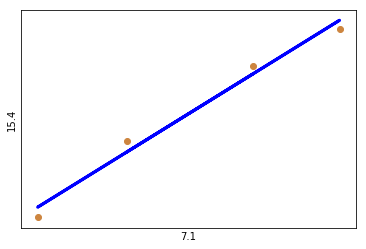

MAE: 0.14335
RAE: 0.14207
RMSE: 0.14419
R2: 0.983
Targets:  7.1 15.4
--------------------------




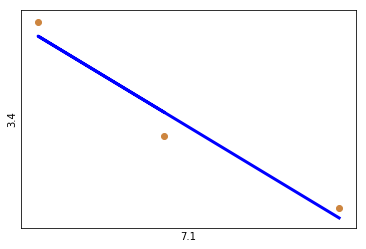

MAE: 0.13813
RAE: 0.24419
RMSE: 0.14718
R2: 0.949
Targets:  7.1 3.4
--------------------------


Targets:  7.1 17.2
--------------------------




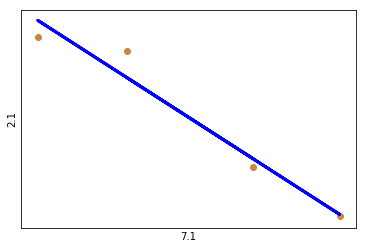

MAE: 0.12610
RAE: 0.18531
RMSE: 0.15333
R2: 0.952
Targets:  7.1 2.1
--------------------------




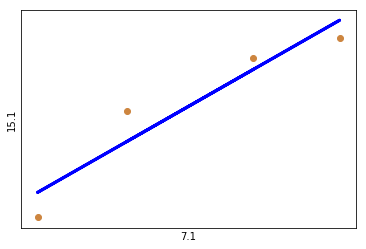

MAE: 0.34468
RAE: 0.36273
RMSE: 0.36297
R2: 0.898
Targets:  7.1 15.1
--------------------------


Targets:  7.1 9.c
--------------------------




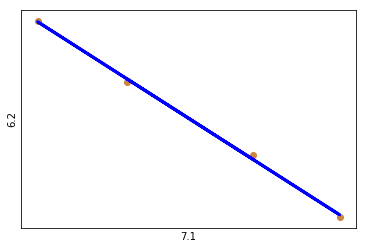

MAE: 0.03497
RAE: 0.03527
RMSE: 0.03965
R2: 0.999
Targets:  7.1 6.2
--------------------------




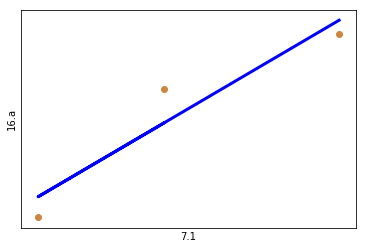

MAE: 0.25128
RAE: 0.33047
RMSE: 0.26774
R2: 0.899
Targets:  7.1 16.a
--------------------------




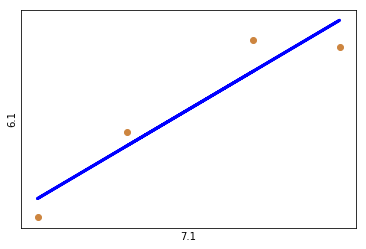

MAE: 0.33270
RAE: 0.34123
RMSE: 0.34788
R2: 0.895
Targets:  7.1 6.1
--------------------------


Targets:  7.1 8.1
--------------------------


Targets:  7.1 7.2
--------------------------


Targets:  7.1 16.3
--------------------------




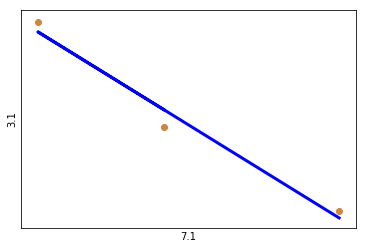

MAE: 0.10866
RAE: 0.17921
RMSE: 0.11578
R2: 0.974
Targets:  7.1 3.1
--------------------------


Targets:  7.1 17.19
--------------------------




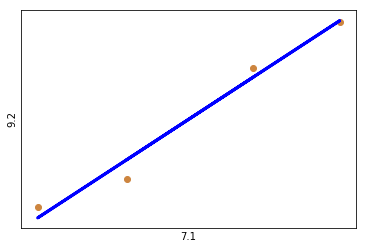

MAE: 0.10563
RAE: 0.14048
RMSE: 0.12612
R2: 0.974
Targets:  7.1 9.2
--------------------------


Targets:  7.1 14.4
--------------------------




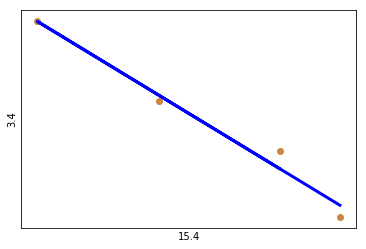

MAE: 0.10558
RAE: 0.14196
RMSE: 0.13152
R2: 0.977
Targets:  15.4 3.4
--------------------------




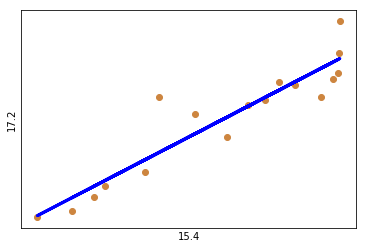

MAE: 0.26063
RAE: 0.31622
RMSE: 0.35577
R2: 0.866
Targets:  15.4 17.2
--------------------------




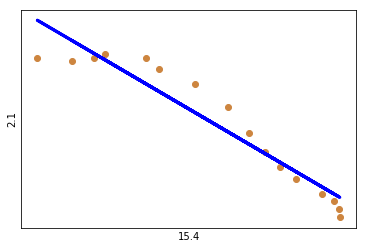

MAE: 0.16494
RAE: 0.26773
RMSE: 0.19955
R2: 0.910
Targets:  15.4 2.1
--------------------------




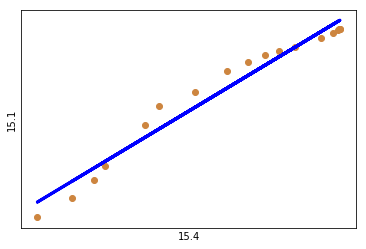

MAE: 0.16931
RAE: 0.20331
RMSE: 0.18739
R2: 0.963
Targets:  15.4 15.1
--------------------------


Targets:  15.4 9.c
--------------------------




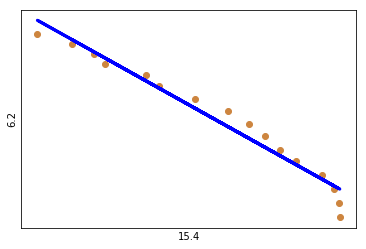

MAE: 0.15442
RAE: 0.18339
RMSE: 0.19346
R2: 0.960
Targets:  15.4 6.2
--------------------------




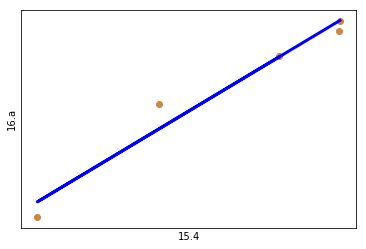

MAE: 0.12906
RAE: 0.17278
RMSE: 0.17138
R2: 0.963
Targets:  15.4 16.a
--------------------------




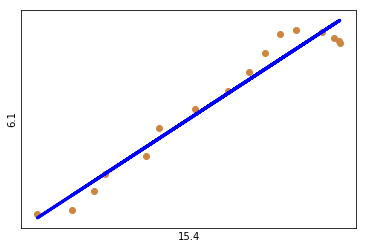

MAE: 0.16525
RAE: 0.19058
RMSE: 0.19922
R2: 0.958
Targets:  15.4 6.1
--------------------------


Targets:  15.4 8.1
--------------------------


Targets:  15.4 7.2
--------------------------


Targets:  15.4 16.3
--------------------------




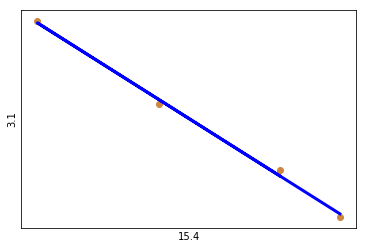

MAE: 0.04321
RAE: 0.05613
RMSE: 0.04740
R2: 0.997
Targets:  15.4 3.1
--------------------------


Targets:  15.4 17.19
--------------------------


Targets:  15.4 9.2
--------------------------


Targets:  15.4 14.4
--------------------------




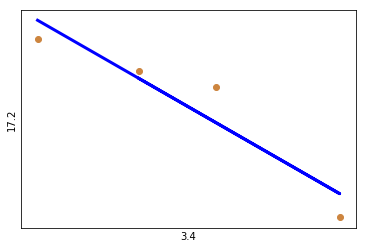

MAE: 0.34099
RAE: 0.37624
RMSE: 0.37823
R2: 0.878
Targets:  3.4 17.2
--------------------------




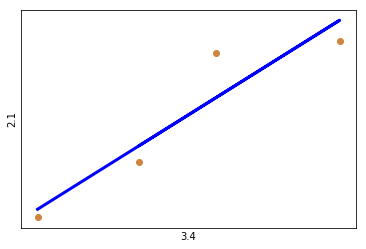

MAE: 0.21798
RAE: 0.31090
RMSE: 0.25616
R2: 0.876
Targets:  3.4 2.1
--------------------------




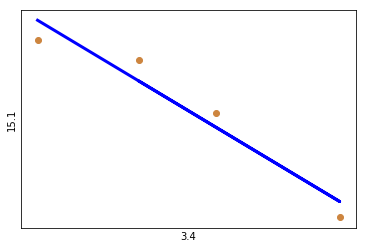

MAE: 0.29363
RAE: 0.30816
RMSE: 0.29684
R2: 0.932
Targets:  3.4 15.1
--------------------------


Targets:  3.4 9.c
--------------------------




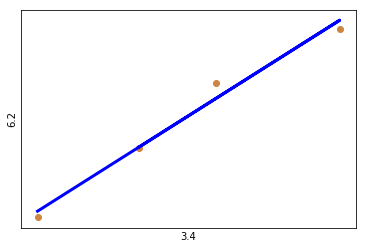

MAE: 0.13007
RAE: 0.12365
RMSE: 0.15805
R2: 0.982
Targets:  3.4 6.2
--------------------------




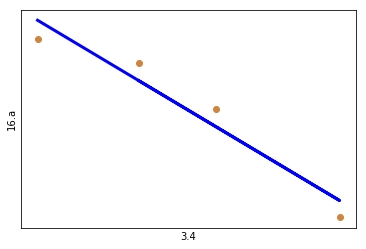

MAE: 0.23055
RAE: 0.31499
RMSE: 0.23087
R2: 0.933
Targets:  3.4 16.a
--------------------------




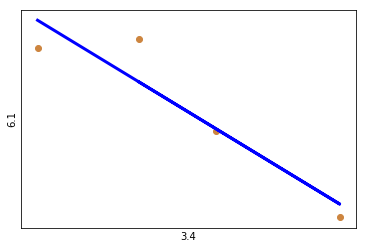

MAE: 0.31796
RAE: 0.32946
RMSE: 0.38994
R2: 0.866
Targets:  3.4 6.1
--------------------------


Targets:  3.4 8.1
--------------------------


Targets:  3.4 7.2
--------------------------


Targets:  3.4 16.3
--------------------------




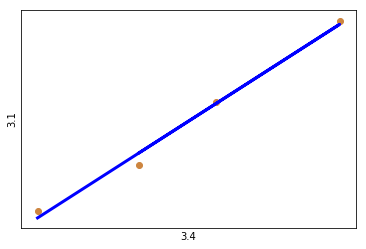

MAE: 0.07449
RAE: 0.09678
RMSE: 0.08945
R2: 0.989
Targets:  3.4 3.1
--------------------------


Targets:  3.4 17.19
--------------------------




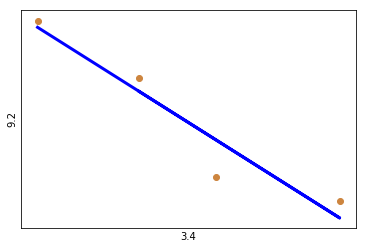

MAE: 0.20935
RAE: 0.26347
RMSE: 0.24614
R2: 0.912
Targets:  3.4 9.2
--------------------------


Targets:  3.4 14.4
--------------------------


Targets:  17.2 2.1
--------------------------




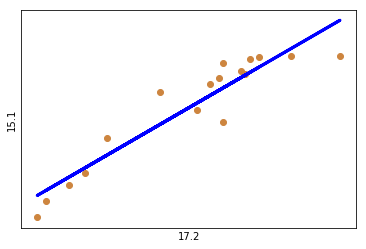

MAE: 0.27798
RAE: 0.33161
RMSE: 0.33677
R2: 0.881
Targets:  17.2 15.1
--------------------------


Targets:  17.2 9.c
--------------------------




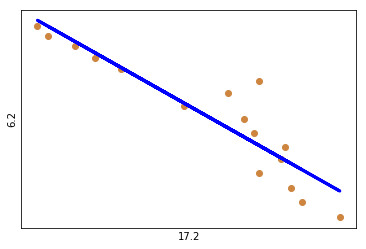

MAE: 0.28666
RAE: 0.34043
RMSE: 0.39318
R2: 0.835
Targets:  17.2 6.2
--------------------------




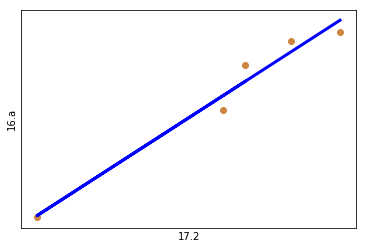

MAE: 0.14593
RAE: 0.19535
RMSE: 0.16158
R2: 0.967
Targets:  17.2 16.a
--------------------------




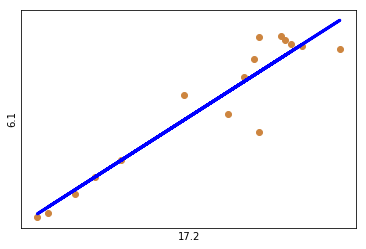

MAE: 0.23385
RAE: 0.26970
RMSE: 0.32882
R2: 0.885
Targets:  17.2 6.1
--------------------------


Targets:  17.2 8.1
--------------------------


Targets:  17.2 7.2
--------------------------


Targets:  17.2 16.3
--------------------------




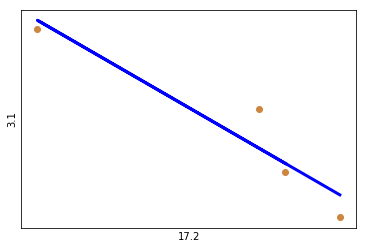

MAE: 0.24158
RAE: 0.31386
RMSE: 0.28677
R2: 0.890
Targets:  17.2 3.1
--------------------------


Targets:  17.2 17.19
--------------------------


Targets:  17.2 9.2
--------------------------


Targets:  17.2 14.4
--------------------------


Targets:  2.1 15.1
--------------------------




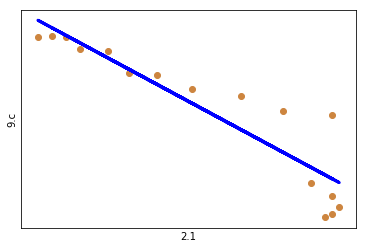

MAE: 0.30942
RAE: 0.36834
RMSE: 0.39566
R2: 0.833
Targets:  2.1 9.c
--------------------------




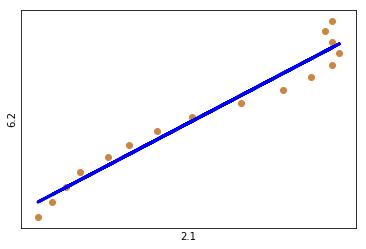

MAE: 0.18307
RAE: 0.21741
RMSE: 0.21111
R2: 0.952
Targets:  2.1 6.2
--------------------------


Targets:  2.1 16.a
--------------------------




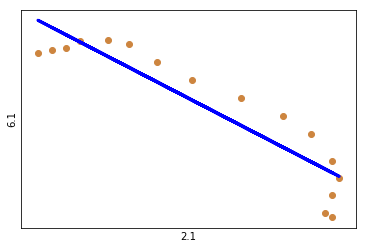

MAE: 0.34098
RAE: 0.39325
RMSE: 0.38660
R2: 0.841
Targets:  2.1 6.1
--------------------------


Targets:  2.1 8.1
--------------------------


Targets:  2.1 7.2
--------------------------




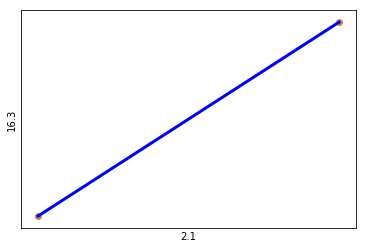

MAE: 0.00000
RAE: nan
RMSE: 0.00000
R2: nan
Targets:  2.1 16.3
--------------------------




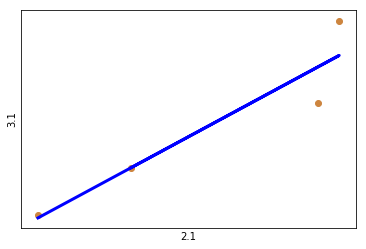

MAE: 0.22127
RAE: 0.28747
RMSE: 0.29734
R2: 0.882
Targets:  2.1 3.1
--------------------------


Targets:  2.1 17.19
--------------------------


Targets:  2.1 9.2
--------------------------




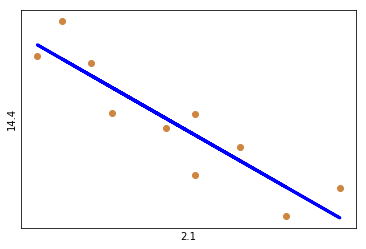

MAE: 0.37079
RAE: 0.47288
RMSE: 0.40832
R2: 0.816
Targets:  2.1 14.4
--------------------------


Targets:  15.1 9.c
--------------------------




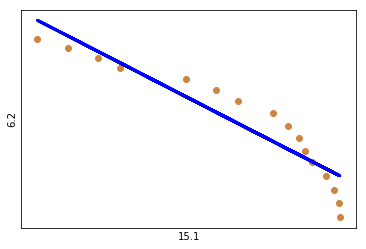

MAE: 0.29911
RAE: 0.35522
RMSE: 0.34831
R2: 0.871
Targets:  15.1 6.2
--------------------------




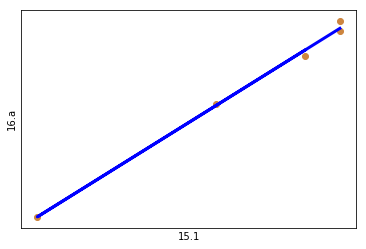

MAE: 0.04321
RAE: 0.05784
RMSE: 0.05447
R2: 0.996
Targets:  15.1 16.a
--------------------------




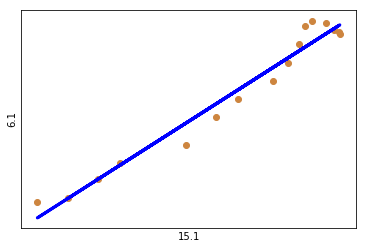

MAE: 0.14713
RAE: 0.16968
RMSE: 0.18246
R2: 0.964
Targets:  15.1 6.1
--------------------------


Targets:  15.1 8.1
--------------------------


Targets:  15.1 7.2
--------------------------




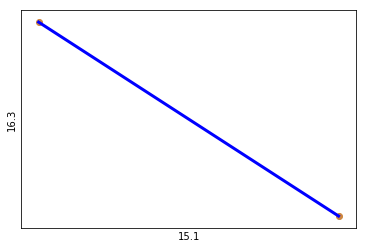

MAE: 0.00000
RAE: nan
RMSE: 0.00000
R2: nan
Targets:  15.1 16.3
--------------------------




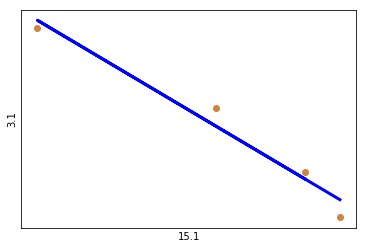

MAE: 0.15454
RAE: 0.20078
RMSE: 0.16538
R2: 0.964
Targets:  15.1 3.1
--------------------------


Targets:  15.1 17.19
--------------------------


Targets:  15.1 9.2
--------------------------


Targets:  15.1 14.4
--------------------------


Targets:  9.c 6.2
--------------------------


Targets:  9.c 16.a
--------------------------


Targets:  9.c 6.1
--------------------------


Targets:  9.c 8.1
--------------------------


Targets:  9.c 7.2
--------------------------


Targets:  9.c 16.3
--------------------------


Targets:  9.c 3.1
--------------------------


Targets:  9.c 17.19
--------------------------


Targets:  9.c 9.2
--------------------------


Targets:  9.c 14.4
--------------------------




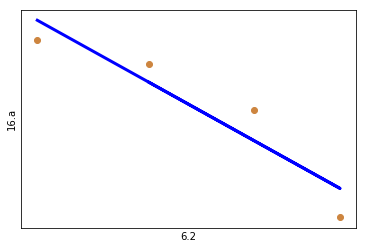

MAE: 0.32047
RAE: 0.43785
RMSE: 0.32804
R2: 0.865
Targets:  6.2 16.a
--------------------------




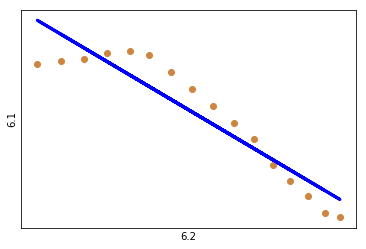

MAE: 0.31227
RAE: 0.36014
RMSE: 0.34936
R2: 0.870
Targets:  6.2 6.1
--------------------------


Targets:  6.2 8.1
--------------------------


Targets:  6.2 7.2
--------------------------


Targets:  6.2 16.3
--------------------------




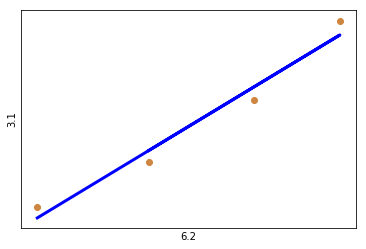

MAE: 0.15363
RAE: 0.19959
RMSE: 0.15407
R2: 0.968
Targets:  6.2 3.1
--------------------------


Targets:  6.2 17.19
--------------------------


Targets:  6.2 9.2
--------------------------


Targets:  6.2 14.4
--------------------------




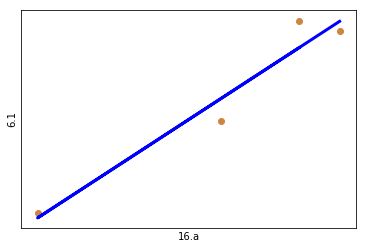

MAE: 0.21700
RAE: 0.22485
RMSE: 0.24803
R2: 0.946
Targets:  16.a 6.1
--------------------------


Targets:  16.a 8.1
--------------------------


Targets:  16.a 7.2
--------------------------


Targets:  16.a 16.3
--------------------------




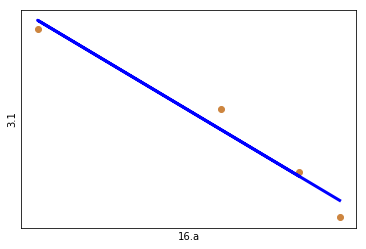

MAE: 0.15460
RAE: 0.20086
RMSE: 0.17342
R2: 0.960
Targets:  16.a 3.1
--------------------------


Targets:  16.a 17.19
--------------------------




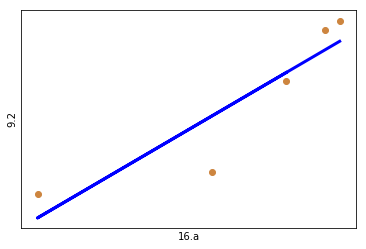

MAE: 0.32009
RAE: 0.38515
RMSE: 0.37623
R2: 0.821
Targets:  16.a 9.2
--------------------------


Targets:  16.a 14.4
--------------------------


Targets:  6.1 8.1
--------------------------


Targets:  6.1 7.2
--------------------------


Targets:  6.1 16.3
--------------------------




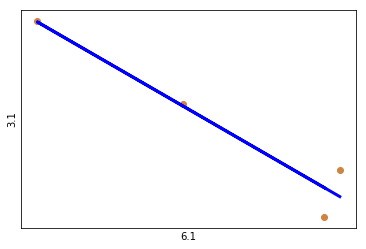

MAE: 0.17113
RAE: 0.22233
RMSE: 0.23289
R2: 0.928
Targets:  6.1 3.1
--------------------------


Targets:  6.1 17.19
--------------------------


Targets:  6.1 9.2
--------------------------




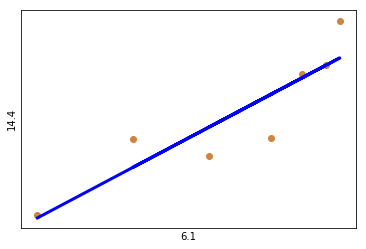

MAE: 0.26196
RAE: 0.38594
RMSE: 0.33520
R2: 0.813
Targets:  6.1 14.4
--------------------------


Targets:  8.1 7.2
--------------------------


Targets:  8.1 16.3
--------------------------


Targets:  8.1 3.1
--------------------------


Targets:  8.1 17.19
--------------------------


Targets:  8.1 9.2
--------------------------


Targets:  8.1 14.4
--------------------------


Targets:  7.2 16.3
--------------------------


Targets:  7.2 3.1
--------------------------


Targets:  7.2 17.19
--------------------------


Targets:  7.2 9.2
--------------------------


Targets:  7.2 14.4
--------------------------


Targets:  16.3 3.1
--------------------------


Targets:  16.3 17.19
--------------------------


Targets:  16.3 9.2
--------------------------


Targets:  16.3 14.4
--------------------------


Targets:  3.1 17.19
--------------------------




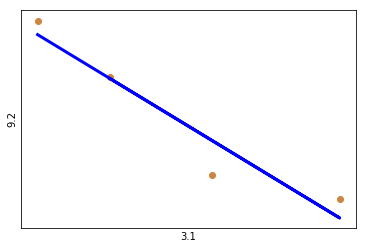

MAE: 0.19870
RAE: 0.25006
RMSE: 0.24068
R2: 0.916
Targets:  3.1 9.2
--------------------------


Targets:  3.1 14.4
--------------------------


Targets:  17.19 9.2
--------------------------


Targets:  17.19 14.4
--------------------------


Targets:  9.2 14.4
--------------------------




In [52]:
keptPairs = list()
processedPairs = list()
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}


for targetx in targets:     #loop over all targets
        
        for targety in targets:
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    p_r = calcCorr(final_t_shuffled, targetx, targety)
                    
                    
                    # filter out independant variables
                    if (coefThreshold < np.abs(p_r) < 1):
                            
                        keptPairs.extend([tuple((targetx, targety))])

                        if p_r > 0: edge_color = 'g'#edgecolor.append('g')
                        else: edge_color = 'r'
                                    
                        edgecolor.append(edge_color)
                        pairsAndRel[targetx, targety] = edge_color
                        
                        
                        X = final_t_shuffled[targetx].reshape(-1,1)
                        Y = final_t_shuffled[targety].reshape(-1,1)
                        
                        # apply mask to lists to filter out pairs containing any NaNs
                        mask = ~pd.isnull(X) & ~pd.isnull(Y)

                        X = X[mask].reshape(-1, 1)
                        Y = Y[mask].reshape(-1, 1)
                        
                        linreg = linear_model.LinearRegression()
                        linreg.fit(X, Y)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X)
                        
                        mae, rae, rmse, r2 = compute_error(Y, y_pred)
                        
                        plt.scatter(X, Y, color='peru')
                        plt.plot(X, y_pred, color='blue', linewidth=3)

                        plt.xticks(())
                        plt.yticks(())
                        plt.xlabel(targetx)
                        plt.ylabel(targety)
                        plt.show()
                        
                        print("MAE: %.5f\nRAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rae, rmse, r2))

                    else: discardedPairs.extend([[targetx, targety]])

                    print('Targets: ', targetx, targety)
                    print('--------------------------')
                    print('\n')

#print(keptPairs)

In [53]:
print("Total number of connections found: ", len(keptPairs))
print("The following target pairs have a linear correlation:", keptPairs)

Total number of connections found:  192
The following target pairs have a linear correlation: [('8.4', '17.3'), ('8.4', '14.5'), ('8.4', '17.8'), ('8.4', '4.2'), ('8.4', '9.4'), ('8.4', '9.5'), ('8.4', '3.3'), ('8.4', '3.9'), ('8.4', '7.1'), ('8.4', '15.4'), ('8.4', '3.4'), ('8.4', '17.2'), ('8.4', '15.1'), ('8.4', '6.2'), ('8.4', '16.a'), ('8.4', '6.1'), ('8.4', '3.1'), ('12.2', '17.3'), ('12.2', '14.5'), ('12.2', '17.8'), ('12.2', '4.2'), ('12.2', '9.4'), ('12.2', '9.5'), ('12.2', '3.3'), ('12.2', '3.9'), ('12.2', '7.1'), ('12.2', '15.4'), ('12.2', '3.4'), ('12.2', '17.2'), ('12.2', '15.1'), ('12.2', '6.2'), ('12.2', '16.a'), ('12.2', '6.1'), ('12.2', '3.1'), ('17.3', '14.5'), ('17.3', '17.8'), ('17.3', '9.4'), ('17.3', '9.5'), ('17.3', '10.c'), ('17.3', '3.3'), ('17.3', '3.9'), ('17.3', '7.1'), ('17.3', '15.4'), ('17.3', '3.4'), ('17.3', '17.2'), ('17.3', '2.1'), ('17.3', '15.1'), ('17.3', '6.2'), ('17.3', '16.a'), ('17.3', '6.1'), ('17.3', '3.1'), ('14.5', '17.8'), ('14.5', '9.4'),

### Graphical Models

In [54]:
import networkx as nx

In [55]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

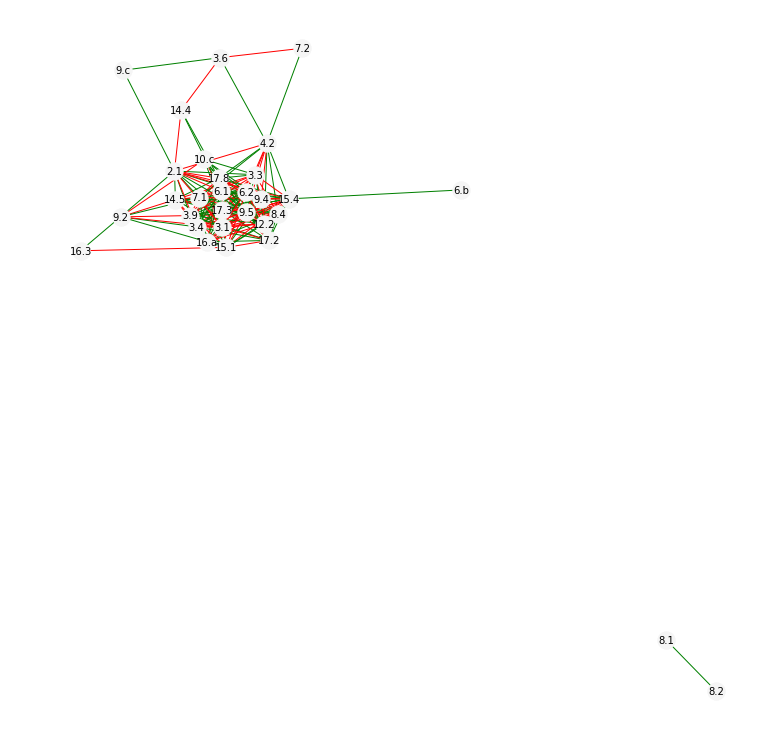

In [56]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(10,10)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph and are plotted closer together. There are also some targets that are only connected to one other target.

Positive interconnections are indicated by a green, negative by a red edge.

In [31]:
# plot a circle as a background to see the ones with most connections clearer
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
#overlay.show()
#overlay.save("final.png")

# 2. Build temporal model to infer missing observations - observing covariance in the residuals

We have a temporal model with missing observations as NaNs, and want to infer them according to their connected targets and their own time series development. Therefore, we design a linear dynamical system with inputs, including an autoregressive model of order 2.

## Define STAN model

With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets connected?**

**2. What are expectable values for missing observations (i.e. imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

    multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}


**Note** that we want to make the missing observation dependent on two previous observations. This is equivalent to define an autoregressive model of order 2.

<img src="pgm.png">

In [32]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs1];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis1];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs2];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis2];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}

transformed data {
    int<lower = 0> T = N_obs1 + N_mis1;  // length of the time-series
}

parameters {
    vector[2] beta[2];            // state transition coefficients 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;     // uncertainty in the latent space
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}

transformed parameters {
    real y1[T];
    real y2[T];
    matrix[2,2] L_sigma;
    y1[ix_obs1] = y_obs1;
    y1[ix_mis1] = y_mis1;
    y2[ix_obs2] = y_obs2;
    y2[ix_mis2] = y_mis2;
}

model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(1);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,5);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first latent state
    z[2,:] ~ normal(0,1);           // prior on second latent state
    
    for(t in 3:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-2):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-2):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

## What is observed, what is missing?

- N_obs: Number of observed values (length of loc array)
- N_mis: Number of missing values (length of loc array)
- ix_obs: indices of observed values
- ix_mis: indices of missing values
- y_obs: observed values

In [33]:
# prepare data for STAN model
def prepareInputData(df, target1, target2):
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
    
    ix_obs1 = np.where(~np.isnan(t1_list))[0]
    ix_obs2 = np.where(~np.isnan(t2_list))[0]
    
    ix_mis1 = np.where(np.isnan(t1_list))[0]
    ix_mis2 = np.where(np.isnan(t2_list))[0]
    
    y_obs1 = [t1_list[index] for index in ix_obs1]
    y_obs2 = [t2_list[index] for index in ix_obs2]
    
    N_obs1 = len(ix_obs1)
    N_obs2 = len(ix_obs2)
    
    N_mis1 = len(ix_mis1)
    N_mis2 = len(ix_mis2)
    
    data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
            'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
            'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}
    
    return data

In [34]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c8db35d3d6b106a2010ff56a7e73b8 NOW.


CPU times: user 1.38 s, sys: 80.1 ms, total: 1.46 s
Wall time: 1min 9s


### How we find the highest correlated pairs of time-series
We use here Pearson's r as a correlation coefficient what returns us *only* the pairs of random variables which are highest correlated in a linear manner. But, the world is not linear; so, we could have also used [this](http://old.econ.ucdavis.edu/faculty/cameron/research/je97preprint.pdf) correlation coefficient.

We calculate the covariance matrix Omega for each possible connection. For the purpose of brevity, we only iterate 500 times. To have valid results, at least 2000 iterations would be more appropriate.

In [46]:
omegaList = []
fitdict = {}
sampledict = {}
for pair in processedPairs:
    if len(pair) > 1:
        targetx = list(pair)[0]
        targety = list(pair)[1]

        # prepare input data
        inData = prepareInputData(final_t, targetx, targety)
        print(pair)

        # run inference using MCMC sampling
        fit = sm.sampling(data=inData, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
        
        sample = fit.extract(permuted=True)
        
        Omega = sample['Omega'][1,0][1]
        
        print(Omega)
        print('-----')
        
        if Omega > Omegathres:
            omegaList.append(pair)
            fitdict['{}{}'.format(targetx, targety)] = fit
            sampledict['{}{}'.format(targetx, targety)] = sample
            
        

{'8.4', '12.2'}


/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


0.9999939109529659
-----
{'8.4', '17.3'}
-0.6925863198779922
-----
{'14.5', '8.4'}
0.2224955672029248
-----
{'8.4', '8.2'}
0.967237090810668
-----
{'8.4', '1.1'}
0.8130533536619847
-----
{'8.4', '17.8'}
-0.6245083348142688
-----
{'8.4', '3.6'}
0.5442445681431257
-----
{'8.4', '4.2'}
0.957074750436459
-----
{'8.4', '9.4'}
0.9831794716775016
-----
{'8.4', '6.b'}
0.0538178159785567
-----
{'9.5', '8.4'}
0.7653598714249938
-----
{'10.c', '8.4'}
0.3099826689842375
-----
{'8.4', '3.3'}
-0.5774384997014336
-----
{'8.4', '3.9'}
-0.4397019504758599
-----
{'8.4', '15.2'}
0.046771299898500894
-----
{'7.1', '8.4'}
0.5474049537415822
-----
{'8.4', '15.4'}
0.42804970054730224
-----
{'3.4', '8.4'}
-0.25313672536024223
-----
{'17.2', '8.4'}
0.9748268873817976
-----
{'8.4', '2.1'}
-0.5083646291330415
-----
{'15.1', '8.4'}
0.6363918524303915
-----
{'8.4', '9.c'}
-0.10814356952471418
-----
{'8.4', '6.2'}
0.23304612367489808
-----
{'8.4', '16.a'}
-0.42853580429341204
-----
{'6.1', '8.4'}
0.6601851705771499

-0.004631127597536406
-----
{'16.3', '17.8'}
-0.9073947270868812
-----
{'3.1', '17.8'}
-0.8674076727934082
-----
{'17.19', '17.8'}
0.02512659659698739
-----
{'9.2', '17.8'}
-0.03185507773340263
-----
{'14.4', '17.8'}
0.11741426337073294
-----
{'4.2', '3.6'}
-0.11378759081523385
-----
{'9.4', '3.6'}
0.40349024637025127
-----
{'3.6', '6.b'}
0.5871614245470914
-----
{'9.5', '3.6'}
0.6678151598770873
-----
{'10.c', '3.6'}
-0.9155868551744593
-----
{'3.3', '3.6'}
0.12025155221567592
-----
{'3.6', '3.9'}
0.35674237374047096
-----
{'3.6', '15.2'}
0.058878640373676565
-----
{'7.1', '3.6'}
-0.2560986009481114
-----
{'15.4', '3.6'}
0.6776559250463579
-----
{'3.4', '3.6'}
0.519703878899389
-----
{'17.2', '3.6'}
-0.15287657326461826
-----
{'3.6', '2.1'}
0.6283857221898681
-----
{'15.1', '3.6'}
0.45597138930603703
-----
{'3.6', '9.c'}
-0.5559149460145837
-----
{'6.2', '3.6'}
-0.6001441896057621
-----
{'3.6', '16.a'}
-0.6705086304542224
-----
{'6.1', '3.6'}
-0.20301385804434494
-----
{'8.1', '3.6'}


0.05942058812004467
-----
{'15.1', '7.1'}
-0.044449415543566094
-----
{'7.1', '9.c'}
0.9348218056116671
-----
{'7.1', '6.2'}
-0.37098829385632587
-----
{'7.1', '16.a'}
0.7698346497585509
-----
{'6.1', '7.1'}
0.5838585868603237
-----
{'8.1', '7.1'}
-0.5234460925883258
-----
{'7.2', '7.1'}
0.8774763409784386
-----
{'7.1', '16.3'}
0.6454206505586652
-----
{'7.1', '3.1'}
-0.7879586551400533
-----
{'7.1', '17.19'}
0.025699696479304382
-----
{'9.2', '7.1'}
0.3466760727428776
-----
{'7.1', '14.4'}
0.05650133169702444
-----
{'3.4', '15.4'}
0.22277066672163567
-----
{'17.2', '15.4'}
-0.5923772446784816
-----
{'15.4', '2.1'}
-0.3077444821572762
-----
{'15.1', '15.4'}
0.9069736944932859
-----
{'15.4', '9.c'}
0.9000319663022791
-----
{'6.2', '15.4'}
-0.14057545394758308
-----
{'15.4', '16.a'}
-0.470601588372817
-----
{'6.1', '15.4'}
-0.6571963540709774
-----
{'8.1', '15.4'}
0.11683084221148646
-----
{'7.2', '15.4'}
-0.09653540393885543
-----
{'16.3', '15.4'}
-0.2176186095112348
-----
{'3.1', '15.4

Now, we would like to find those pairs of targets that are connected by both causation and in their temporal dependency.

In [49]:
print(omegaList)

[{'8.4', '12.2'}, {'8.4', '8.2'}, {'8.4', '1.1'}, {'8.4', '3.6'}, {'8.4', '4.2'}, {'8.4', '9.4'}, {'9.5', '8.4'}, {'7.1', '8.4'}, {'17.2', '8.4'}, {'15.1', '8.4'}, {'6.1', '8.4'}, {'8.4', '17.19'}, {'8.4', '14.4'}, {'8.2', '12.2'}, {'9.4', '12.2'}, {'9.5', '12.2'}, {'3.9', '12.2'}, {'15.2', '12.2'}, {'7.1', '12.2'}, {'15.4', '12.2'}, {'17.2', '12.2'}, {'15.1', '12.2'}, {'16.a', '12.2'}, {'6.1', '12.2'}, {'16.3', '12.2'}, {'17.8', '17.3'}, {'4.2', '17.3'}, {'9.5', '17.3'}, {'16.3', '17.3'}, {'17.19', '17.3'}, {'14.5', '8.2'}, {'14.5', '9.4'}, {'14.5', '6.b'}, {'14.5', '15.2'}, {'14.5', '2.1'}, {'14.5', '16.a'}, {'14.5', '8.1'}, {'14.5', '9.2'}, {'8.2', '1.1'}, {'8.2', '3.6'}, {'9.4', '8.2'}, {'9.5', '8.2'}, {'10.c', '8.2'}, {'7.1', '8.2'}, {'8.1', '8.2'}, {'8.2', '17.19'}, {'9.2', '8.2'}, {'1.1', '6.b'}, {'7.1', '1.1'}, {'1.1', '16.a'}, {'16.3', '1.1'}, {'17.19', '1.1'}, {'1.1', '14.4'}, {'6.b', '17.8'}, {'9.c', '17.8'}, {'6.1', '17.8'}, {'8.1', '17.8'}, {'3.6', '6.b'}, {'9.5', '3.6'}, 

In [58]:
print(keptPairs)

[('8.4', '17.3'), ('8.4', '14.5'), ('8.4', '17.8'), ('8.4', '4.2'), ('8.4', '9.4'), ('8.4', '9.5'), ('8.4', '3.3'), ('8.4', '3.9'), ('8.4', '7.1'), ('8.4', '15.4'), ('8.4', '3.4'), ('8.4', '17.2'), ('8.4', '15.1'), ('8.4', '6.2'), ('8.4', '16.a'), ('8.4', '6.1'), ('8.4', '3.1'), ('12.2', '17.3'), ('12.2', '14.5'), ('12.2', '17.8'), ('12.2', '4.2'), ('12.2', '9.4'), ('12.2', '9.5'), ('12.2', '3.3'), ('12.2', '3.9'), ('12.2', '7.1'), ('12.2', '15.4'), ('12.2', '3.4'), ('12.2', '17.2'), ('12.2', '15.1'), ('12.2', '6.2'), ('12.2', '16.a'), ('12.2', '6.1'), ('12.2', '3.1'), ('17.3', '14.5'), ('17.3', '17.8'), ('17.3', '9.4'), ('17.3', '9.5'), ('17.3', '10.c'), ('17.3', '3.3'), ('17.3', '3.9'), ('17.3', '7.1'), ('17.3', '15.4'), ('17.3', '3.4'), ('17.3', '17.2'), ('17.3', '2.1'), ('17.3', '15.1'), ('17.3', '6.2'), ('17.3', '16.a'), ('17.3', '6.1'), ('17.3', '3.1'), ('14.5', '17.8'), ('14.5', '9.4'), ('14.5', '9.5'), ('14.5', '3.3'), ('14.5', '3.9'), ('14.5', '7.1'), ('14.5', '15.4'), ('14.5'

In [61]:
connections = []
for pair in omegaList:
    if pair in keptPairs: connections.append(list(pair))
        
print('Number of pairs that have a causal and temporal relationship: ', len(connections))
print(connections)

Number of pairs that have a causal and temporal relationship:  0
[]


These connected pairs are then further examined by imputing missing values for each of them.

In [ ]:
for pair in connections:
    targetx = pair[0]
    targety = pair[1]

    # prepare input data
    inData = prepareInputData(final_t, targetx, targety)
    print(pair)

    # run inference using MCMC sampling
    fit = fitdict['{}{}'.format(targetx, targety)]
    
    # what do we actually want to show? sigma and tau are performance measurements.
    fit.plot(["tau","lp__"]) # take vars from temporal model
    plt.show()

    samples = sampledict['{}{}'.format(targetx, targety)]
    
    # get values for plots
    # convert indices back to year values
    ix_mis1 = inData['ix_mis1']+startyear
    ix_mis2 = inData['ix_mis2']+startyear
    ix_obs1 = inData['ix_obs1']+startyear
    ix_obs2 = inData['ix_obs2']+startyear
    
    # extract imputed and known values and renormalize them
    y_mis1 = samples['y_mis1'].mean(axis=0) * std_df[targetx] + mean_df[targetx]
    y_mis2 = samples['y_mis2'].mean(axis=0) * std_df[targety] + mean_df[targety]
    y_obs1 = np.array(inData['y_obs1']) * std_df[targetx] + mean_df[targetx]
    y_obs2 = np.array(inData['y_obs2']) * std_df[targety] + mean_df[targety]
    
    # define title and labels from original dataframe
    y1_df = merged_df[merged_df['Target']==pair[0]]
    y2_df = merged_df[merged_df['Target']==pair[1]]
    y1_title = 'Target '+pair[0]+'\n'+str(y1_df['Indicator Description'].values).replace('[','').replace(']','')
    y1_label = str(y1_df['Unit'].values).replace('[','').replace(']','')
    y2_title = 'Target '+pair[0]+'\n'+str(y2_df['Indicator Description'].values).replace('[','').replace(']','')
    y2_label = str(y2_df['Unit'].values).replace('[','').replace(']','')
    
    # plot with imputed values of target 1
    plt.plot(ix_obs1, y_obs1, "bo")
    plt.plot(ix_mis1, y_mis1, "bx")
    plt.title(y1_title)
    plt.legend(["observed values","imputed values"])
    plt.xlabel('year')
    plt.ylabel(y1_label)
    plt.show()
    
    # plot with imputed values of target 2
    plt.plot(ix_obs2, y_obs2, "bo")
    plt.plot(ix_mis2, y_mis2, "bx")
    plt.title(y2_title)
    plt.legend(["observed values", "imputed values"])
    plt.xlabel('year')
    plt.ylabel(y2_label)
    plt.show()

## Conclusion
- We were able to prove that there are strong linear correlations (correlation coefficient higher than the pre-defined threshold value) between the time-series of some targets.
- Some dependencies might still remain undiscovered which could be identified by a correlation different from a linear one, e.g. exponential
- The second measure for the strength of the connection is the covariance which was calculated using the STAN-model. It gives an idea how strong the causal relationship between the targets is, leaving out the time dimension.
- We have to be critical about the imputed values in the years where data for both targets are missing (only dependant on the prior), but can be rather confident on imputed values that have an observation in the correlated target.
- Some of the predictions for y can only be given low confidence as the number of effective values used for this prediction is very low.
- **We have way too less data to prove a causation between any two Targets. Causation is only guaranteed if also the a fully randomized control group is taken into account. We do not have this, and therefore can only assume a causal relationship.**

## Prospect: What we can do next
- use inferred values and/or identified relations to make predictions for the future based on assumptions of the development of one indicator
- find "plan of action" to improve one target/reach one target